In [1]:
import pycisTopic
import glob
import os
import pybiomart as pbm
import pandas as pd
import pickle
from pycisTopic.qc import *
from IPython.display import Image, display
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import palettable

%matplotlib inline
%load_ext lab_black

In [67]:
def list_files(startpath):
    for root, dirs, files in os.walk(startpath):
        level = root.replace(startpath, "").count(os.sep)
        indent = " " * 4 * (level)
        print("{}{}/".format(indent, os.path.basename(root)))
        subindent = " " * 4 * (level + 1)
        for f in files:
            print("{}{}".format(subindent, f))

# 1. Run basic cisTopic analysis

Define which type of output you want to run the QC notebook on. This can be either `PUMATAC`, `cellranger-atac` or `cellranger-arc`.  
For `PUMATAC`, simply list the `PUMATAC` output directory, which will contain subdirectories for all samples.
For `cellranger-atac` and `cellranger-arc`, list a master directory which contains the cellranger output directories.

In [62]:
output_type = "PUMATAC"
# output_type = "cellranger-atac"
# output_type = "cellranger-arc"

Define the output directory:

In [2]:
output_dir = "ATACflow_tutorial_preprocessing_out"

In [68]:
list_files(output_dir)

ATACflow_tutorial_preprocessing_out/
    data/
        fragments/
            EPF_hydrop_1.fragments.raw.tsv.gz.tbi
            OHS_s3atac_1.fragments.tsv.original_CB_to_merged_CBs.tsv
            EPF_hydrop_1.fragments.tsv.original_CB_to_merged_CBs.tsv
            OHS_s3atac_1.fragments.raw.tsv.gz.tbi
            VIB_10xv2_1.fragments.tsv.original_CB_to_merged_CBs.tsv
            EPF_hydrop_1.fragments.tsv.gz
            EPF_hydrop_1.fragments.raw.tsv.gz
            BIO_ddseq_4.fragments.tsv.original_CB_to_merged_CBs.tsv
            OHS_s3atac_1.fragments.tsv.gz
            EPF_hydrop_1.fragments.tsv.gz.tbi
            VIB_10xv2_1.fragments.raw.tsv.gz.tbi
            VIB_10xv2_1.fragments.tsv.gz.tbi
            BIO_ddseq_4.fragments.tsv.gz.tbi
            VIB_10xv2_1.fragments.raw.tsv.gz
            VIB_10xv2_1.fragments.tsv.gz
            OHS_s3atac_1.fragments.raw.tsv.gz
            BIO_ddseq_4.fragments.tsv.gz
            OHS_s3atac_1.fragments.tsv.gz.tbi
            BIO_ddseq_4.fr

### Find paths to fragments
This should find fragments files generated by ATACflow (should be in a NextFlow output directory with suffix `preprocessing_out`).

In [3]:
fragments_paths_dict = {
    os.path.basename(x).split(".fragments.tsv.gz")[0]: x
    for x in glob.glob(f"{output_dir}/data/fragments/*fragments.tsv.gz")
}
fragments_paths_dict

{'EPF_hydrop_1': 'ATACflow_tutorial_preprocessing_out/data/fragments/EPF_hydrop_1.fragments.tsv.gz',
 'OHS_s3atac_1': 'ATACflow_tutorial_preprocessing_out/data/fragments/OHS_s3atac_1.fragments.tsv.gz',
 'VIB_10xv2_1': 'ATACflow_tutorial_preprocessing_out/data/fragments/VIB_10xv2_1.fragments.tsv.gz',
 'BIO_ddseq_4': 'ATACflow_tutorial_preprocessing_out/data/fragments/BIO_ddseq_4.fragments.tsv.gz'}

### Define which genome should be used for each sample
Create a dummy `genome_dict` first which has `hg38` by default, then adjust where necessary (valid values for this notebook at `hg38` and `mm10`, if you work with other genomes, you can manually add gene annotation and regions as you please).

In [4]:
genome_dict = {
    os.path.basename(x).split(".fragments.tsv.gz")[0]: "hg38"
    for x in glob.glob(f"{output_dir}/data/fragments/*fragments.tsv.gz")
}
genome_dict

{'EPF_hydrop_1': 'hg38',
 'OHS_s3atac_1': 'hg38',
 'VIB_10xv2_1': 'hg38',
 'BIO_ddseq_4': 'hg38'}

You can manually set this here:

In [5]:
genome_dict = {
    "OHS_s3atac_1": "hg38",
    "VIB_10xv2_1": "hg38",
    "EPF_hydrop_1": "hg38",
    "BIO_ddseq_4": "hg38",
}

Check if all samples are included:

In [6]:
if not set(genome_dict.keys()) == set(fragments_paths_dict.keys()):
    print("Warning, not all fragments files have genomes defined.")

Create an inverse dictionary, listing the samples per genome.

In [7]:
inverse_genome_dict = {}
for sample, genome in genome_dict.items():
    if genome not in inverse_genome_dict:
        inverse_genome_dict[genome] = []
    inverse_genome_dict[genome].append(sample)

inverse_genome_dict

{'hg38': ['OHS_s3atac_1', 'VIB_10xv2_1', 'EPF_hydrop_1', 'BIO_ddseq_4']}

### Download a gene annotation from biomart

In [8]:
pbm_genome_name_dict = {
    "hg38": "hsapiens_gene_ensembl",
    "hg37": "hsapiens_gene_ensembl",
    "mm10": "mmusculus_gene_ensembl",
    "dm6": "dmelanogaster_gene_ensembl",
}

pbm_host_dict = {
    "hg38": "http://www.ensembl.org",
    "hg37": "http://grch37.ensembl.org/",
    "mm10": "http://nov2020.archive.ensembl.org/",
    "dm6": "http://www.ensembl.org",
}

annotation_dict = {}
for genome in inverse_genome_dict.keys():
    if os.path.exists(f"{genome}_annotation.tsv"):
        print(f"Loading cached genome annotation {genome}_annotation.tsv")
        annotation = pd.read_csv(
            f"{genome}_annotation.tsv", sep="\t", header=0, index_col=0
        )
        annotation_dict[genome] = annotation
    else:
        dataset = pbm.Dataset(
            name=pbm_genome_name_dict[genome], host=pbm_host_dict[genome]
        )

        annotation = dataset.query(
            attributes=[
                "chromosome_name",
                "transcription_start_site",
                "strand",
                "external_gene_name",
                "transcript_biotype",
            ]
        )
        filter = annotation["Chromosome/scaffold name"].str.contains("CHR|GL|JH|MT")
        annotation = annotation[~filter]
        annotation["Chromosome/scaffold name"] = annotation[
            "Chromosome/scaffold name"
        ].str.replace(r"(\b\S)", r"chr\1")
        annotation.columns = [
            "Chromosome",
            "Start",
            "Strand",
            "Gene",
            "Transcript_type",
        ]
        annotation = annotation[annotation.Transcript_type == "protein_coding"]
        annotation.to_csv(f"{genome}_annotation.tsv", sep="\t")

        annotation_dict[genome] = annotation

Loading cached genome annotation hg38_annotation.tsv


### Define which regions to use to generate cisTopic count matrix
Ideally this should be cluster consensus peaks called on each sample individually, but for rough QC purposes, the ENCODE SCREEN regions suffice.  
I have a copy of these regions in the `resources` subdir:

In [9]:
screen_path_dict = {
    os.path.basename(x).split("-")[0].split(".")[-1]: x
    for x in sorted(
        glob.glob("PUMATAC_dependencies/regions/V2*-rDHS-Unfiltered.blacklisted.bed")
    )
}
screen_path_dict

{'hg38': 'PUMATAC_dependencies/regions/V2.hg38-rDHS-Unfiltered.blacklisted.bed',
 'mm10': 'PUMATAC_dependencies/regions/V2.mm10-rDHS-Unfiltered.blacklisted.bed'}

In [10]:
regions_paths_dict = {
    os.path.basename(x).split(".fragments.tsv.gz")[0]: screen_path_dict[genome]
    for x in glob.glob(f"{output_dir}/data/fragments/*fragments.tsv.gz")
}
regions_paths_dict

{'EPF_hydrop_1': 'PUMATAC_dependencies/regions/V2.hg38-rDHS-Unfiltered.blacklisted.bed',
 'OHS_s3atac_1': 'PUMATAC_dependencies/regions/V2.hg38-rDHS-Unfiltered.blacklisted.bed',
 'VIB_10xv2_1': 'PUMATAC_dependencies/regions/V2.hg38-rDHS-Unfiltered.blacklisted.bed',
 'BIO_ddseq_4': 'PUMATAC_dependencies/regions/V2.hg38-rDHS-Unfiltered.blacklisted.bed'}

Again, if you want, you can manually edit this dictionary and substitute your own regions.

### Run cisTopic quality control tools
cisTopic has a suite of functions which calculate per-barcode quality metrics such as number of (unique) fragments, TSS enrichment, fraction of fragments in peaks and so on. Make a directory for cisTopic output:

In [11]:
cistopic_qc_out = "cistopic_qc_out"
if not os.path.exists(cistopic_qc_out):
    os.makedirs(cistopic_qc_out)

Determine which fragments files have already gone through cisTopic QC (in case you ran this notebook before)

In [12]:
fragments_sub_dict = {}
regions_sub_dict = {}
for sample in fragments_paths_dict.keys():
    metadata_file = os.path.join(cistopic_qc_out, sample + "__metadata_bc.pkl")
    print(f"Checking if {metadata_file} exist...")
    if os.path.exists(metadata_file):
        print("\tMetadata exists! Skipping...")
    else:
        fragments_sub_dict[sample] = fragments_paths_dict[sample]
        print("\tMetadata does not exist, adding to subdict to generate")

regions_sub_dict = {x: regions_paths_dict[x] for x in sorted(fragments_sub_dict.keys())}
regions_sub_dict

Checking if cistopic_qc_out/EPF_hydrop_1__metadata_bc.pkl exist...
	Metadata exists! Skipping...
Checking if cistopic_qc_out/OHS_s3atac_1__metadata_bc.pkl exist...
	Metadata exists! Skipping...
Checking if cistopic_qc_out/VIB_10xv2_1__metadata_bc.pkl exist...
	Metadata exists! Skipping...
Checking if cistopic_qc_out/BIO_ddseq_4__metadata_bc.pkl exist...
	Metadata exists! Skipping...


{}

Then execute cisTopic. The following code will run pycisTopic's QC toolbox on the fragments files provided above. It does so in blocks, where the number of samples per block is defined by `n_cores`. For example, if you have 64 samples, and you define `n_cores = 8`, the following loop will call ray 8 times and run 8 samples each time.

In [13]:
ray.shutdown()

In [14]:
n_cores = 8
for genome, samples in inverse_genome_dict.items():
    print(genome, samples)
    if regions_sub_dict != {}:
        samples_sub = list(set(regions_sub_dict.keys()).intersection(samples))
        blocks = [
            samples_sub[i : i + n_cores] for i in range(0, len(samples_sub), n_cores)
        ]
        print(blocks)
        for samples_torun_in_block in blocks:
            fragments_sub_dict_block = {
                key: fragments_sub_dict[key] for key in samples_torun_in_block
            }
            regions_sub_dict_block = {
                key: regions_sub_dict[key] for key in samples_torun_in_block
            }
            print(f"Running samples {samples_torun_in_block} for genome {genome}")

            metadata_bc_dict, profile_data_dict = compute_qc_stats(
                fragments_dict=fragments_sub_dict_block,
                tss_annotation=annotation_dict[genome],
                stats=[
                    "barcode_rank_plot",
                    "duplicate_rate",
                    "insert_size_distribution",
                    "profile_tss",
                    "frip",
                ],
                label_list=None,
                path_to_regions=regions_sub_dict_block,
                n_cpu=n_cores,
                valid_bc=None,
                n_frag=10,
                n_bc=None,
                tss_flank_window=2000,
                tss_window=50,
                tss_minimum_signal_window=100,
                tss_rolling_window=10,
                # min_norm=0.2,
                remove_duplicates=True,
            )

            ray.shutdown()
            print(f"Done, writing files to {cistopic_qc_out}...")
            for sample in sorted(metadata_bc_dict.keys()):
                metadata_bc_dict[sample]["sample_id"] = sample
                metadata_bc_dict[sample].index = [
                    x + "___" + sample for x in list(metadata_bc_dict[sample].index)
                ]
                with open(
                    os.path.join(cistopic_qc_out, f"{sample}__metadata_bc.pkl"), "wb"
                ) as f:
                    pickle.dump(metadata_bc_dict[sample], f, protocol=4)

                with open(
                    os.path.join(cistopic_qc_out, f"{sample}__profile_data.pkl"), "wb"
                ) as f:
                    pickle.dump(profile_data_dict[sample], f, protocol=4)
    else:
        print("All samples already processed.")

hg38 ['OHS_s3atac_1', 'VIB_10xv2_1', 'EPF_hydrop_1', 'BIO_ddseq_4']
All samples already processed.


We have now calculated various QC metrics and can proceed.

In [15]:
sorted(os.listdir(cistopic_qc_out))

['.ipynb_checkpoints',
 'BIO_ddseq_4__metadata_bc.pkl',
 'BIO_ddseq_4__profile_data.pkl',
 'EPF_hydrop_1__metadata_bc.pkl',
 'EPF_hydrop_1__profile_data.pkl',
 'OHS_s3atac_1__metadata_bc.pkl',
 'OHS_s3atac_1__profile_data.pkl',
 'VIB_10xv2_1__metadata_bc.pkl',
 'VIB_10xv2_1__profile_data.pkl']

### Filter cells from background noise
We then filter true cells (high TSS enrichment, and high number of unique fragments \[in peaks\]). We need the following functions:

In [16]:
import seaborn as sns
import pprint as pp


def histogram(array, nbins=100):
    """
    Draw histogram from distribution and identify centers.
    Parameters
    ---------
    array: `class::np.array`
            Scores distribution
    nbins: int
            Number of bins to use in the histogram
    Return
    ---------
    float
            Histogram values and bin centers.
    """
    array = array.ravel().flatten()
    hist, bin_edges = np.histogram(array, bins=nbins, range=None)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2.0
    return hist, bin_centers


def threshold_otsu(array, nbins=100, min_value=100):
    """
    Apply Otsu threshold on topic-region distributions [Otsu, 1979].
    Parameters
    ---------
    array: `class::np.array`
            Array containing the region values for the topic to be binarized.
    nbins: int
            Number of bins to use in the binarization histogram
    Return
    ---------
    float
            Binarization threshold.
    Reference
    ---------
    Otsu, N., 1979. A threshold selection method from gray-level histograms. IEEE transactions on systems, man, and
    cybernetics, 9(1), pp.62-66.
    """
    array = array[(array >= min_value)]
    hist, bin_centers = histogram(array, nbins)
    hist = hist.astype(float)
    # Class probabilities for all possible thresholds
    weight1 = np.cumsum(hist)
    weight2 = np.cumsum(hist[::-1])[::-1]
    # Class means for all possible thresholds
    mean1 = np.cumsum(hist * bin_centers) / weight1
    mean2 = (np.cumsum((hist * bin_centers)[::-1]) / weight2[::-1])[::-1]
    # Clip ends to align class 1 and class 2 variables:
    # The last value of ``weight1``/``mean1`` should pair with zero values in
    # ``weight2``/``mean2``, which do not exist.
    variance12 = weight1[:-1] * weight2[1:] * (mean1[:-1] - mean2[1:]) ** 2
    idx = np.argmax(variance12)
    threshold = bin_centers[:-1][idx]
    return threshold


# def calc_kde(xy):
#     return gaussian_kde(xy)(xy)


def plot_frag_qc(
    x,
    y,
    ax,
    x_thr_min=None,
    x_thr_max=None,
    y_thr_min=None,
    y_thr_max=None,
    ylab=None,
    xlab="Number of (unique) fragments in regions",
    cmap="viridis",
    density_overlay=False,
    s=10,
    marker="+",
    c="#343434",
    xlim=None,
    ylim=None,
    **kwargs,
):
    from scipy.stats import gaussian_kde

    assert all(x.index == y.index)
    barcodes = x.index.values

    if density_overlay:
        cores = 8

        x_log = np.log(x)

        # Split input array for KDE [log(x), y] array in
        # equaly spaced parts (start_offset + n * nbr_cores).
        kde_parts = [np.vstack([x_log[i::cores], y[i::cores]]) for i in range(cores)]

        # Get nultiprocess context object to spawn processes.
        # mp_ctx = mp.get_context("spawn")

        # Calculate KDE in parallel.
        with Pool(processes=cores) as pool:
            results = pool.map(kde.calc_kde, kde_parts)

        z = np.concatenate(results)

        # now order x and y in the same way that z was ordered, otherwise random z value is assigned to barcode:
        x_ordered = np.concatenate([x[i::cores] for i in range(cores)])
        y_ordered = np.concatenate([y[i::cores] for i in range(cores)])

        idx = (
            z.argsort()
        )  # order based on z value so that highest value is plotted on top, and not hidden by lower values
        x, y, z, barcodes = x_ordered[idx], y_ordered[idx], z[idx], barcodes[idx]
    else:
        z = c

    sp = ax.scatter(x, y, c=z, s=s, edgecolors=None, marker=marker, cmap=cmap, **kwargs)
    if ylim is not None:
        ax.set_ylim(ylim[0], ylim[1])
    if xlim is not None:
        ax.set_xlim(xlim[0], xlim[1])

    # Start with keeping all barcodes.
    barcodes_to_keep = np.full(x.shape[0], True)

    # Filter barcodes out if needed based on thresholds:
    if x_thr_min is not None:
        ax.axvline(x=x_thr_min, color="r", linestyle="--")

    if x_thr_max is not None:
        ax.axvline(x=x_thr_max, color="r", linestyle="--")

    if y_thr_min is not None:
        ax.axhline(y=y_thr_min, color="r", linestyle="--")

    if y_thr_max is not None:
        ax.axhline(y=y_thr_max, color="r", linestyle="--")

    ax.set_xscale("log")
    ax.set_xmargin(0.01)
    ax.set_ymargin(0.01)
    ax.set_xlabel(xlab, fontsize=10)
    ax.set_ylabel(ylab, fontsize=10)


def plot_qc(
    sample,
    min_dict,
    max_dict,
    metadata_bc_df,
    include_kde=False,
    detailed_title=True,
    s=4,
    min_x_val=100,
    min_y_val=1,
):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4), dpi=150)

    # calculate thresholds using a double otsu strategy:
    # first we calculate an otsu threshold using a minimum of 10 fragments
    # then, this otsu threshold is used as the minimum for the second iteration

    x_arr = np.log10(metadata_bc_df["Unique_nr_frag_in_regions"])
    x_threshold_log = threshold_otsu(x_arr, nbins=5000, min_value=np.log10(min_x_val))
    x_threshold = 10**x_threshold_log

    y_arr = metadata_bc_df["TSS_enrichment"]
    y_threshold = threshold_otsu(y_arr, nbins=5000, min_value=min_y_val)

    # calculate cells passing filter
    metadata_bc_df_passing_filters = metadata_bc_df.loc[
        (metadata_bc_df.Unique_nr_frag_in_regions > x_threshold)
        & (metadata_bc_df.TSS_enrichment > y_threshold)
    ]
    bc_passing_filters = metadata_bc_df_passing_filters.index

    # plot everything
    plot_frag_qc(
        x=metadata_bc_df["Unique_nr_frag_in_regions"],
        y=metadata_bc_df["TSS_enrichment"],
        ylab="TSS Enrichment",
        s=s,
        x_thr_min=x_threshold,
        y_thr_min=y_threshold,
        xlim=[10, max_dict["Unique_nr_frag_in_regions"]],
        ylim=[0, max_dict["TSS_enrichment"]],
        density_overlay=include_kde,
        ax=ax1,
    )
    plot_frag_qc(
        x=metadata_bc_df["Unique_nr_frag_in_regions"],
        y=metadata_bc_df["FRIP"],
        x_thr_min=x_threshold,
        ylab="FRIP",
        s=s,
        xlim=[10, max_dict["Unique_nr_frag_in_regions"]],
        ylim=[0, 1],
        density_overlay=include_kde,
        ax=ax2,
    )
    plot_frag_qc(
        x=metadata_bc_df["Unique_nr_frag_in_regions"],
        y=metadata_bc_df["Dupl_rate"],
        x_thr_min=x_threshold,
        ylab="Duplicate rate per cell",
        s=s,
        xlim=[10, max_dict["Unique_nr_frag_in_regions"]],
        ylim=[0, 1],
        density_overlay=include_kde,
        ax=ax3,
    )

    if detailed_title:
        med_nf = round(
            metadata_bc_df.loc[
                bc_passing_filters, "Unique_nr_frag_in_regions"
            ].median(),
            2,
        )
        med_tss = round(
            metadata_bc_df.loc[bc_passing_filters, "TSS_enrichment"].median(), 2
        )
        med_frip = round(metadata_bc_df.loc[bc_passing_filters, "FRIP"].median(), 2)
        title = f"{sample}: Kept {len(bc_passing_filters)} cells using Otsu filtering. Median Unique Fragments: {med_nf:.0f}. Median TSS Enrichment: {med_tss:.2f}. Median FRIP: {med_frip:.2f}\nUsed a minimum of {x_threshold:.2f} fragments and TSS enrichment of {y_threshold:.2f})"
    else:
        title = sample

    fig.suptitle(title, x=0.5, y=0.95, fontsize=10)
    return bc_passing_filters, fig

Then, find the `__metadata_bc.pkl` files we just generated using cisTopic:

In [17]:
metadata_bc_pkl_path_dict = {
    os.path.basename(x).split("__metadata_bc.pkl")[0]: x
    for x in sorted(glob.glob(f"{cistopic_qc_out}/*metadata_bc.pkl"))
}
metadata_bc_pkl_path_dict

{'BIO_ddseq_4': 'cistopic_qc_out/BIO_ddseq_4__metadata_bc.pkl',
 'EPF_hydrop_1': 'cistopic_qc_out/EPF_hydrop_1__metadata_bc.pkl',
 'OHS_s3atac_1': 'cistopic_qc_out/OHS_s3atac_1__metadata_bc.pkl',
 'VIB_10xv2_1': 'cistopic_qc_out/VIB_10xv2_1__metadata_bc.pkl'}

In [18]:
metadata_bc_df_all = pd.DataFrame()
for sample in metadata_bc_pkl_path_dict.keys():
    with open(metadata_bc_pkl_path_dict[sample], "rb") as fh:
        metadata_bc_df = pickle.load(fh)
        metadata_bc_df_all = pd.concat([metadata_bc_df_all, metadata_bc_df])
        print(f"Added {sample} metadata_bc_df")

Added BIO_ddseq_4 metadata_bc_df
Added EPF_hydrop_1 metadata_bc_df
Added OHS_s3atac_1 metadata_bc_df
Added VIB_10xv2_1 metadata_bc_df


Calculate global maxima, will be used to scale plots later

In [19]:
max_dict = {}
min_dict = {}
for stat in metadata_bc_df_all.columns:
    max_dict[stat] = metadata_bc_df_all[stat].max()
    min_dict[stat] = metadata_bc_df_all[stat].min()

pp.pprint(min_dict)
pp.pprint(max_dict)

{'Dupl_nr_frag': 0,
 'Dupl_rate': 0.0,
 'FRIP': 0.0,
 'Log_total_nr_frag': 1.0413926851582251,
 'Log_unique_nr_frag': 1.0413926851582251,
 'TSS_enrichment': 0.0,
 'Total_nr_frag': 11,
 'Total_nr_frag_in_regions': 0,
 'Unique_nr_frag': 11,
 'Unique_nr_frag_in_regions': 0,
 'sample_id': 'BIO_ddseq_4'}
{'Dupl_nr_frag': 191167,
 'Dupl_rate': 0.9364827312425565,
 'FRIP': 1.0,
 'Log_total_nr_frag': 6.048409171969883,
 'Log_unique_nr_frag': 6.019334006496526,
 'TSS_enrichment': 73.98525445063837,
 'Total_nr_frag': 1117916,
 'Total_nr_frag_in_regions': 341523,
 'Unique_nr_frag': 1045524,
 'Unique_nr_frag_in_regions': 319776,
 'sample_id': 'VIB_10xv2_1'}


Now, we will apply Otsu's algorithm on all cells with more than `standard_min_x_val` fragments and a higher than `standard_min_y_val` TSS enrichment. For some samples, the standard minimum values might not produce good results, so these can be edited here if you want. For high quality samples, the standard values should work nicely.

In [20]:
standard_min_x_val = 100
standard_min_y_val = 1
min_otsu_frags_dict = {}
min_otsu_tss_dict = {}
for metadata_bc_pkl_path in sorted(metadata_bc_pkl_path_dict.keys()):
    sample = metadata_bc_pkl_path.split("/")[-1].split("__metadata_bc.pkl")[0]
    tech = sample.split("_")[1]
    if tech == "ddseq":
        min_otsu_frags_dict[sample] = 300
    elif tech == "hydrop":
        min_otsu_frags_dict[sample] = 300
    else:
        min_otsu_frags_dict[sample] = standard_min_x_val

    if tech == "s3atac":
        min_otsu_tss_dict[sample] = 0
    else:
        min_otsu_tss_dict[sample] = standard_min_y_val

pp.pprint(min_otsu_frags_dict)
pp.pprint(min_otsu_tss_dict)

{'BIO_ddseq_4': 300,
 'EPF_hydrop_1': 300,
 'OHS_s3atac_1': 100,
 'VIB_10xv2_1': 100}
{'BIO_ddseq_4': 1, 'EPF_hydrop_1': 1, 'OHS_s3atac_1': 0, 'VIB_10xv2_1': 1}


And here, we actually apply the algorithm in a loop:

In [21]:
kde = False

In [22]:
from IPython.display import Image, display

selected_barcodes/BIO_ddseq_4_bc_passing_filters_otsu.pkl bc passing filters exists, skipping...


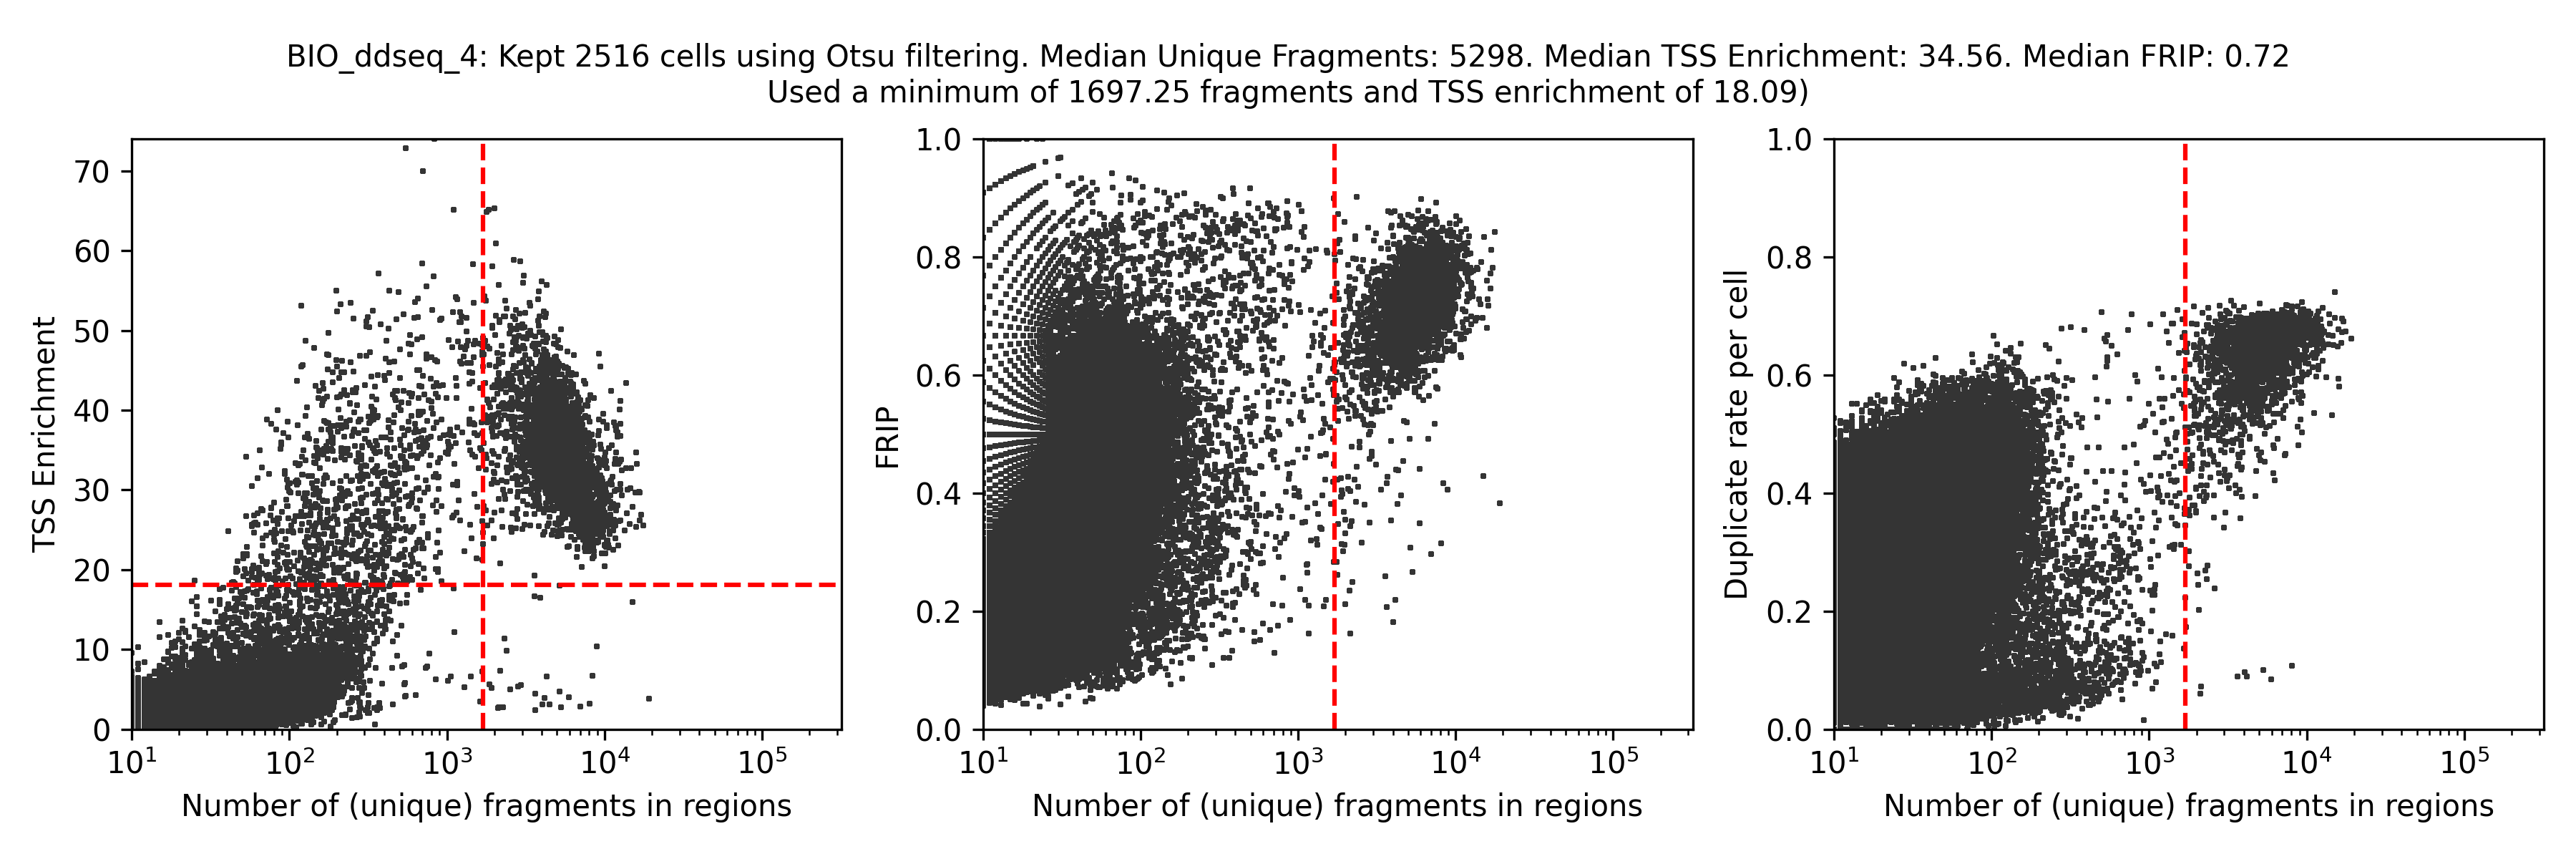

selected_barcodes/EPF_hydrop_1_bc_passing_filters_otsu.pkl bc passing filters exists, skipping...


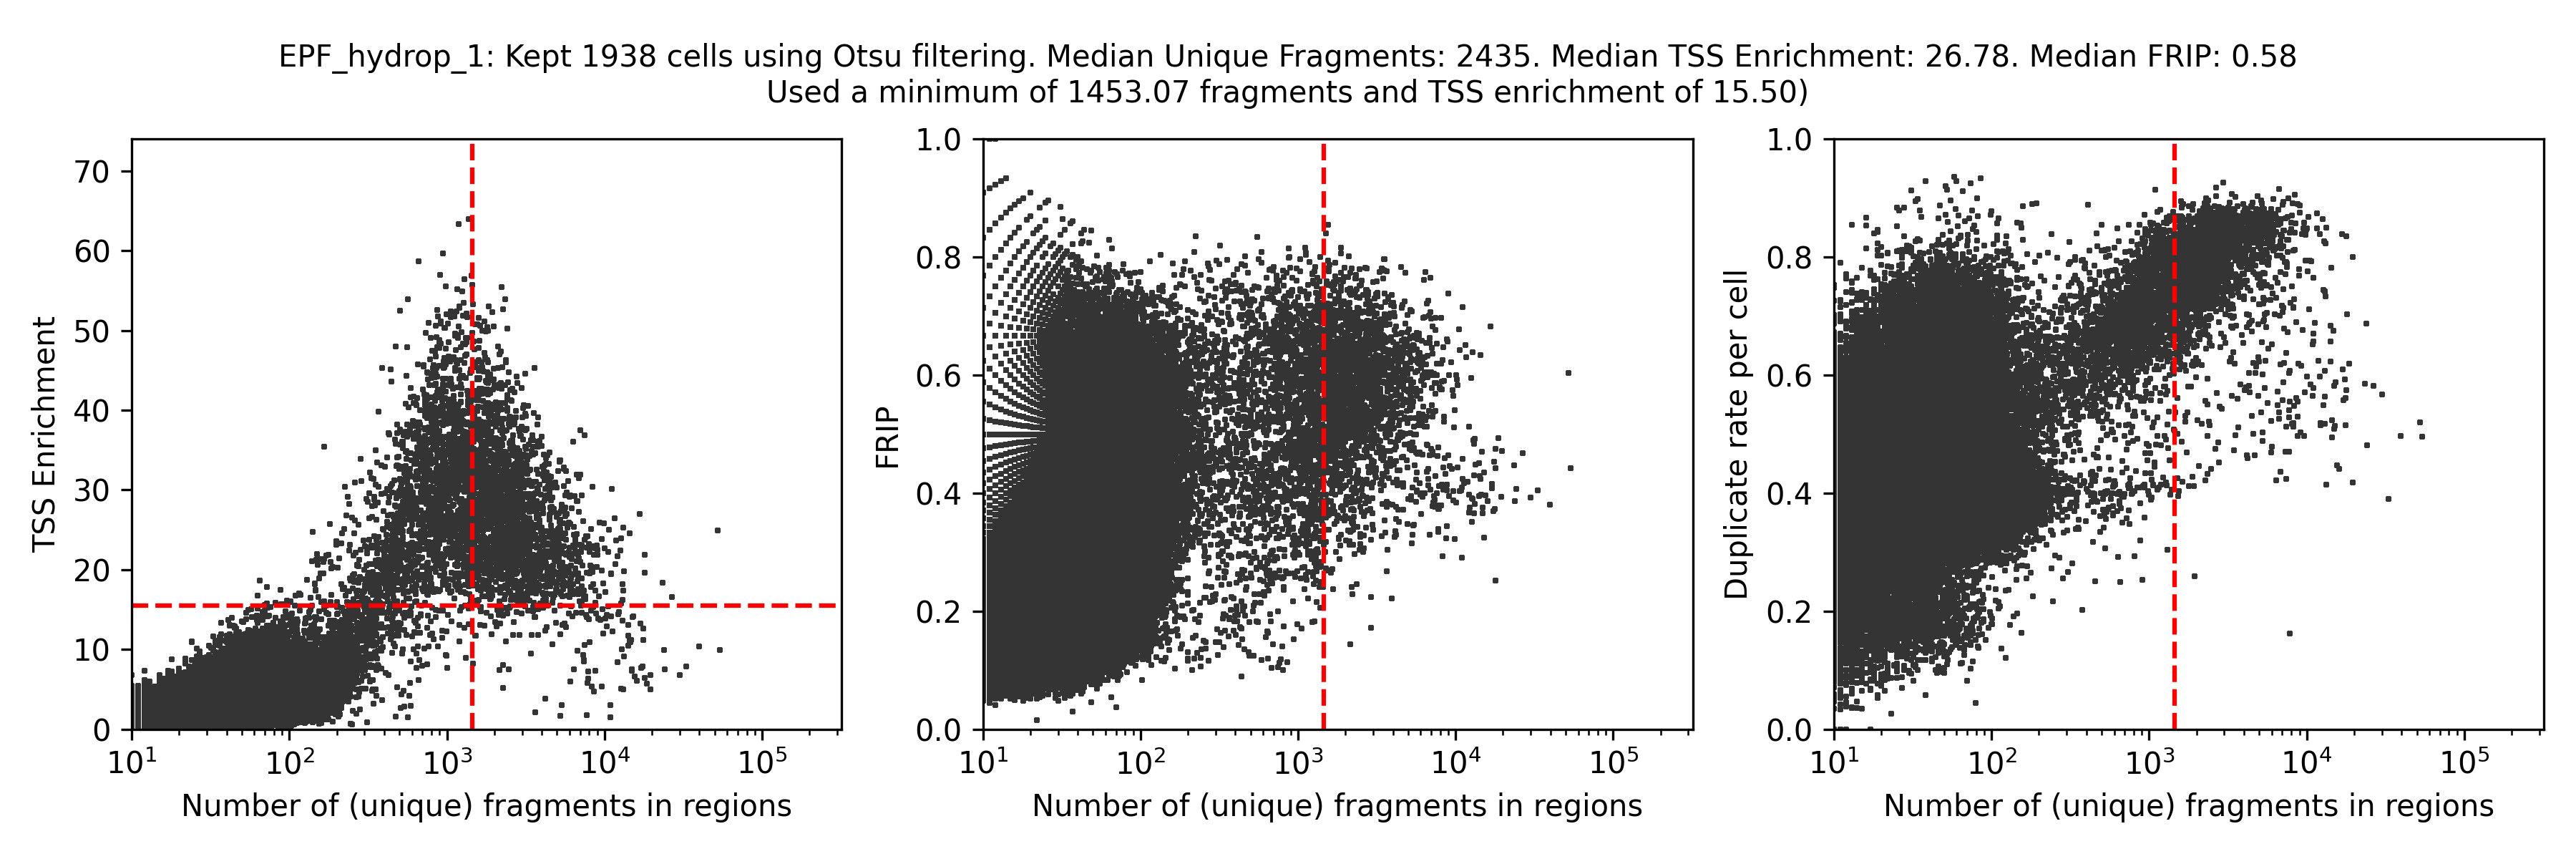

selected_barcodes/OHS_s3atac_1_bc_passing_filters_otsu.pkl bc passing filters exists, skipping...


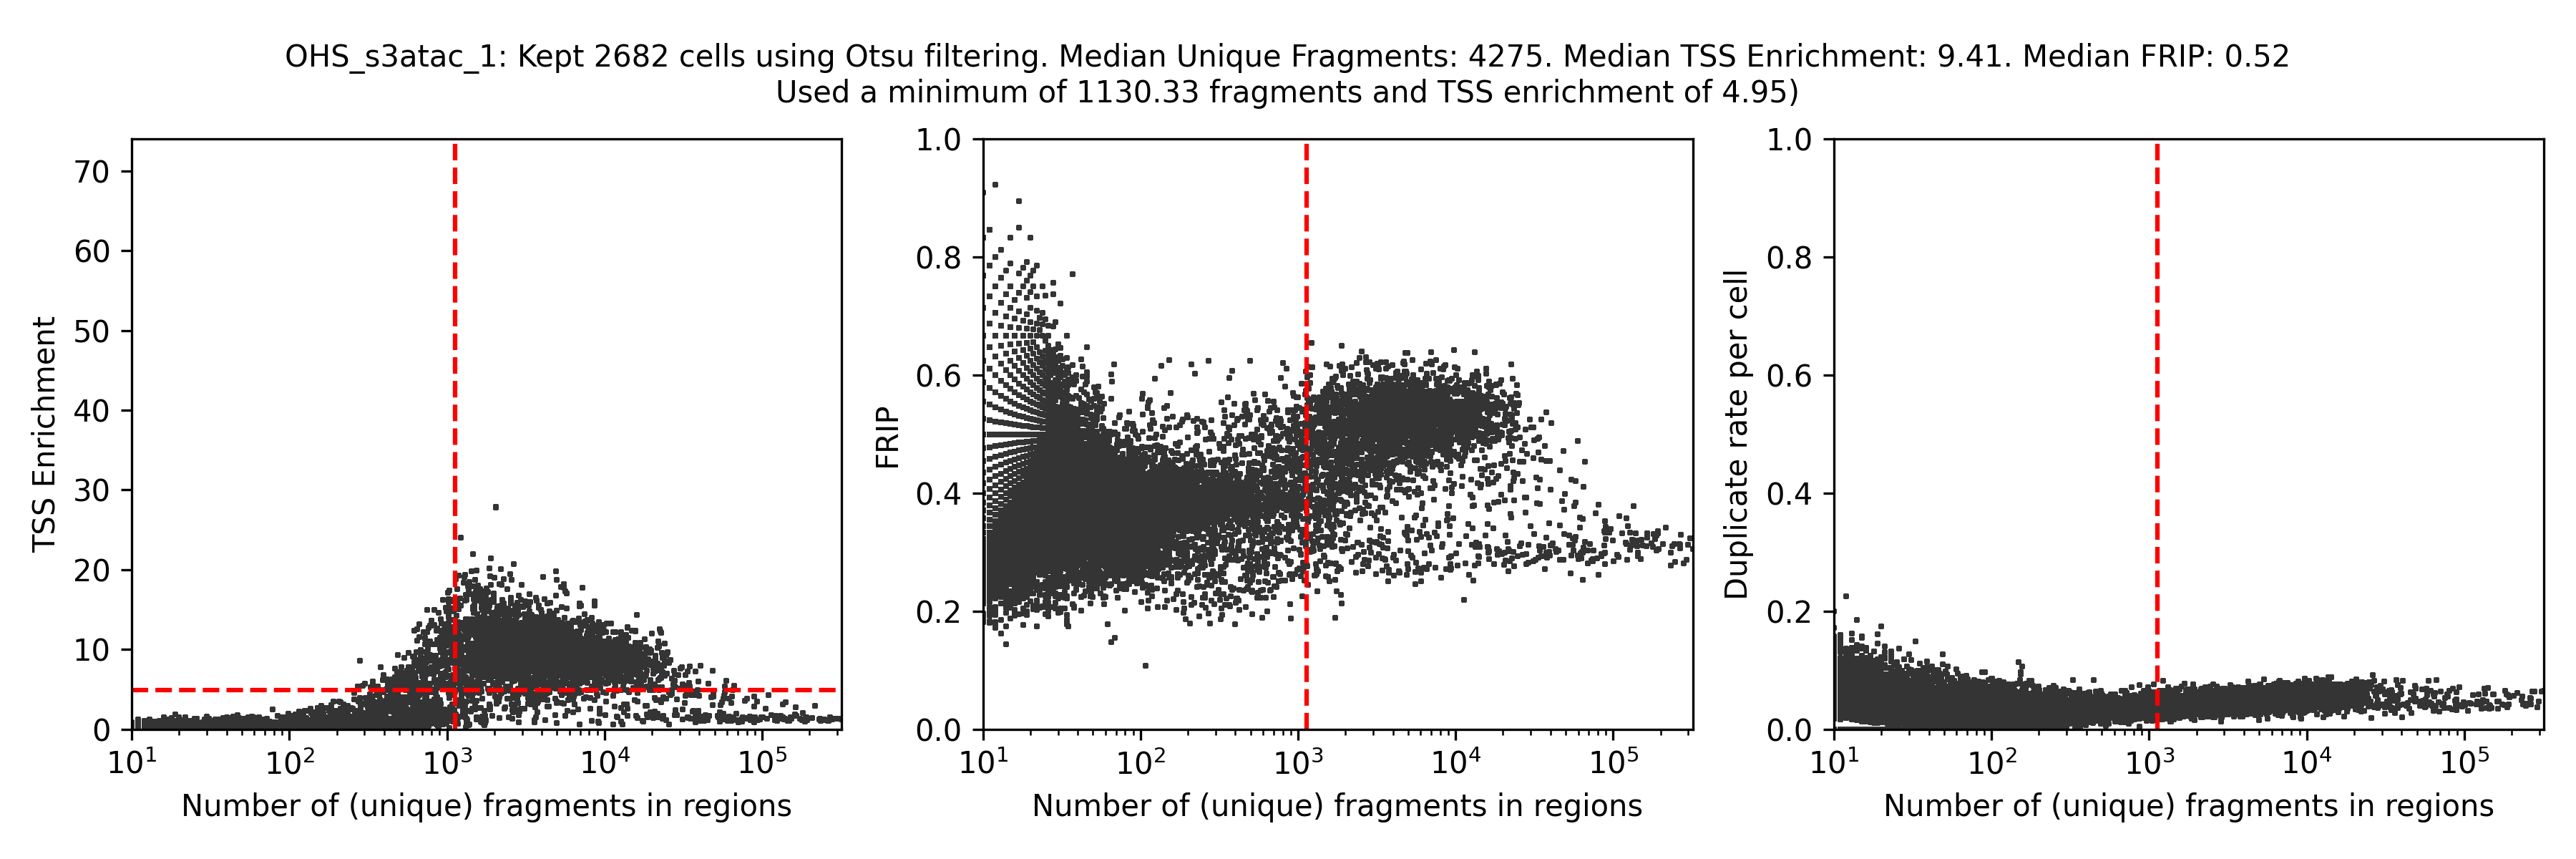

selected_barcodes/VIB_10xv2_1_bc_passing_filters_otsu.pkl bc passing filters exists, skipping...


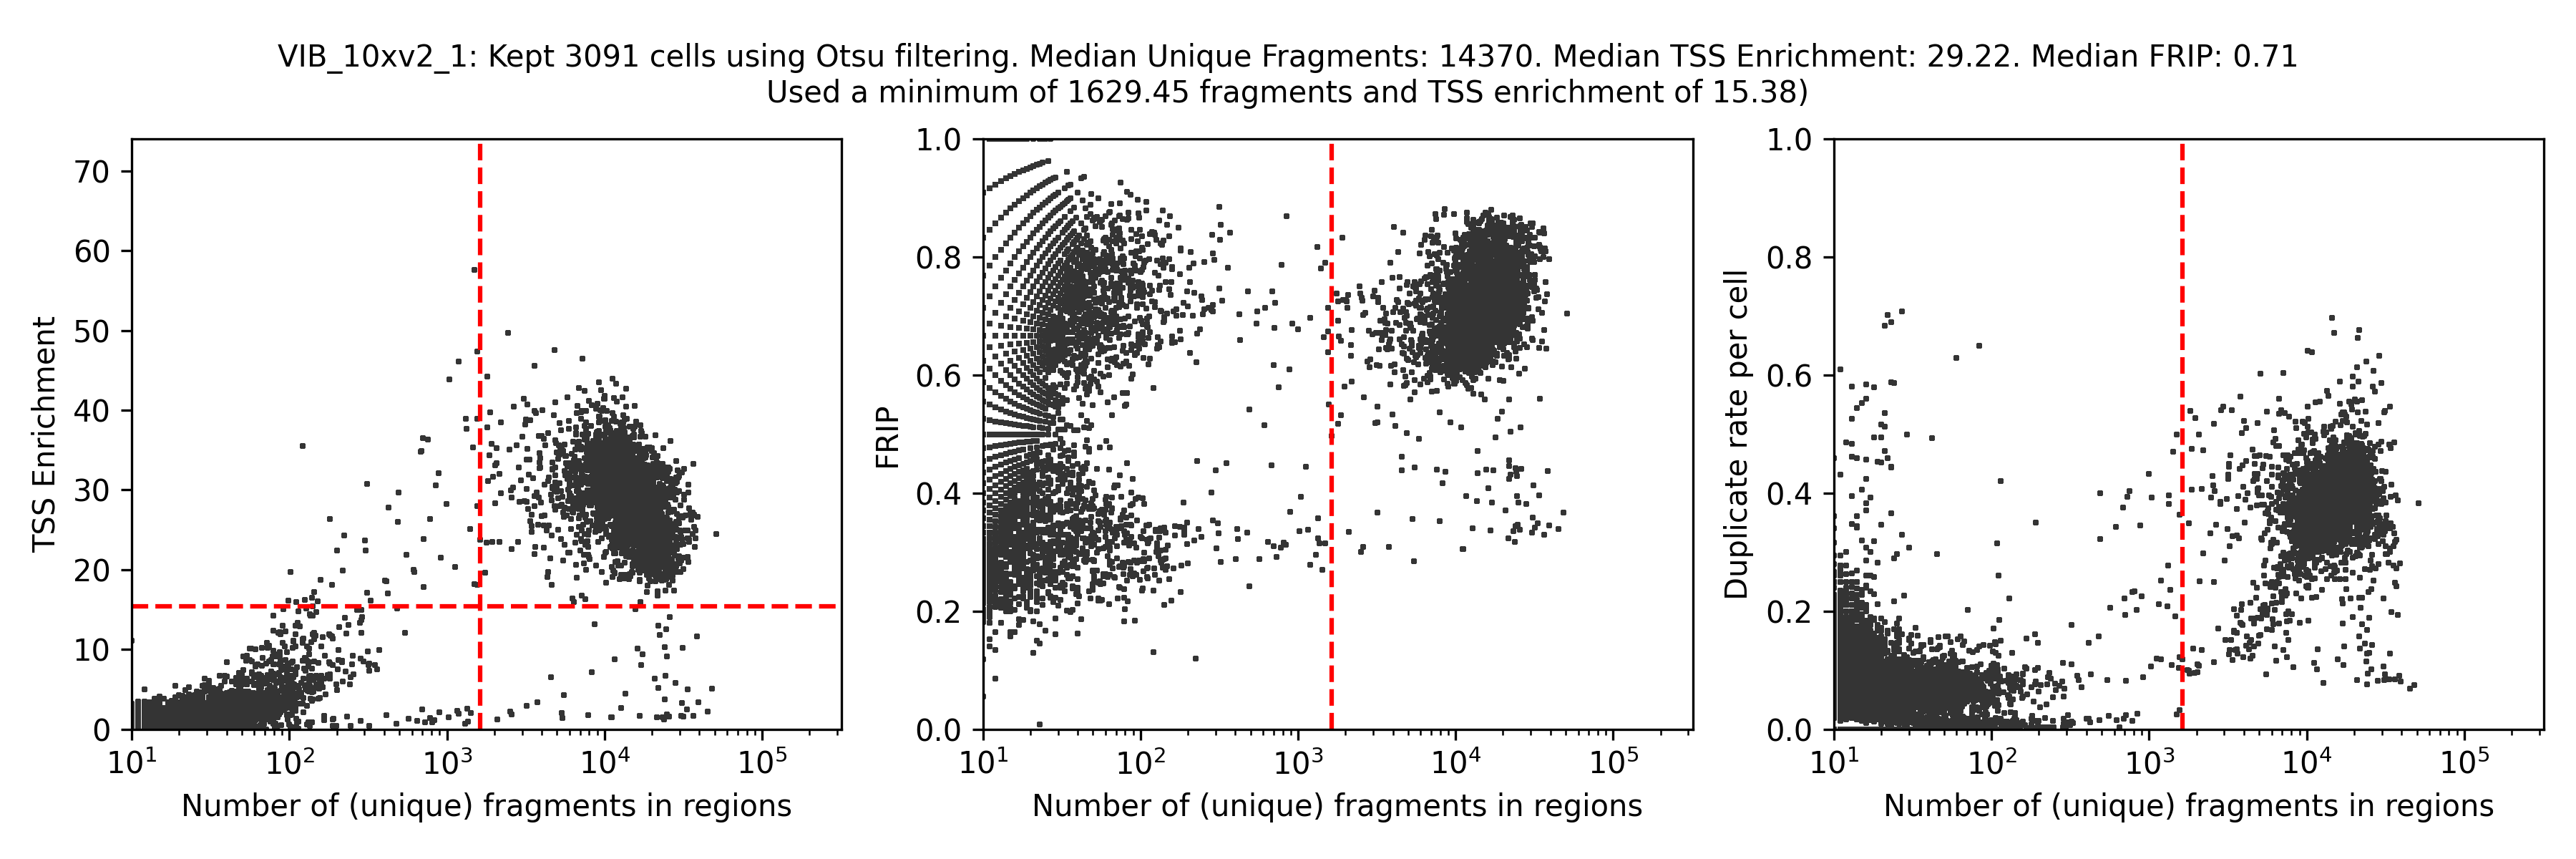

In [23]:
if not os.path.exists("plots_qc"):
    os.mkdir("plots_qc")
if not os.path.exists("selected_barcodes"):
    os.mkdir("selected_barcodes")
for sample in metadata_bc_pkl_path_dict.keys():
    pkl_path = f"selected_barcodes/{sample}_bc_passing_filters_otsu.pkl"
    if os.path.exists(pkl_path):
        print(f"{pkl_path} bc passing filters exists, skipping...")
        display(Image(filename=f"plots_qc/{sample}_qc_otsu.png"))

    else:
        print(f"{pkl_path} bc passing filters does not exist yet, generating...")
        print(f"\tLoading {metadata_bc_pkl_path_dict[sample]}")
        with open(metadata_bc_pkl_path_dict[sample], "rb") as fh:
            metadata_bc_df = pickle.load(fh)

        print(f"\tFiltering cells and generating QC plots.")
        if not sample in min_otsu_frags_dict.keys():
            print(
                f"\t{sample} not in minimum dict! Using standard value of {standard_min_x_val}"
            )
            min_x_val = standard_min_x_val
            min_y_val = standard_min_y_val
        else:
            min_x_val = min_otsu_frags_dict[sample]
            min_y_val = min_otsu_tss_dict[sample]

        bc_passing_filters, fig = plot_qc(
            sample=sample,
            min_dict=min_dict,
            max_dict=max_dict,
            metadata_bc_df=metadata_bc_df,
            include_kde=kde,
            min_x_val=min_x_val,
            min_y_val=min_y_val,
        )

        plt.tight_layout()
        plt.savefig(f"plots_qc/{sample}_qc_otsu.png", dpi=300, facecolor="white")
        plt.show()
        plt.close()

        print(f"\tSaving...")
        with open(
            f"selected_barcodes/{sample}_bc_passing_filters_otsu.pkl", "wb"
        ) as fh:
            pickle.dump(bc_passing_filters, fh)
        fh.close()

        fh = open(f"selected_barcodes/{sample}_bc_passing_filters_otsu.txt", "w")
        for bc in list(bc_passing_filters):
            fh.write(bc + "\n")
        fh.close()

        metadata_bc_df.loc[bc_passing_filters].to_csv(
            f"selected_barcodes/{sample}_metadata_bc_df.tsv", sep="\t"
        )

# 2. Saturation analysis

The following code subsets the `fragments.tsv.gz` file for selected cells, and then calculates the saturation within these selected cells.

In [24]:
#!/usr/bin/env python

### load libs
import gzip
import pandas as pd
import numpy as np
import os
from scipy.optimize import curve_fit
import matplotlib.pylab as plt
import bisect
import random
from collections import Counter
from collections.abc import Sequence
import glob
import pickle
import polars as pl
import scipy

%load_ext lab_black

The lab_black extension is already loaded. To reload it, use:
  %reload_ext lab_black


First, load the barcodes we filtered as cells. Make sure that the barcodes match the barcodes in the fragments files! Take special care to remove any suffixes or prefixes that you may have added to the barcodes. For example, cisTopic adds `__{sample}` as a suffix to each barcode:

In [25]:
selected_barcodes_dict = {}
for filepath in glob.glob("selected_barcodes/*pkl"):
    sample = os.path.basename(filepath).split("_bc")[0]
    with open(filepath, "rb") as f:
        selected_barcodes = list(pickle.load(f))
    selected_barcodes = [x.split("___")[0] for x in selected_barcodes]
    newfilepath = filepath.replace(".pkl", ".RAW.txt")
    with open(newfilepath, "w") as fp:
        for item in selected_barcodes:
            fp.write("%s\n" % item)

    selected_barcodes_dict[sample] = selected_barcodes
selected_barcodes_dict.keys()

dict_keys(['OHS_s3atac_1', 'EPF_hydrop_1', 'BIO_ddseq_4', 'VIB_10xv2_1'])

In [26]:
n_cells_dict = {x: len(y) for x, y in selected_barcodes_dict.items()}
n_cells_dict

{'OHS_s3atac_1': 2682,
 'EPF_hydrop_1': 1938,
 'BIO_ddseq_4': 2516,
 'VIB_10xv2_1': 3091}

Get the number of reads per FASTQ

In [27]:
barcode_stats_dict = {
    os.path.basename(x).split("__")[0]: x
    for x in sorted(glob.glob(f"{output_dir}/data/reports/barcode/*"))
}
barcode_stats_dict

{'BIO_ddseq_4': 'ATACflow_tutorial_preprocessing_out/data/reports/barcode/BIO_ddseq_4_____R1.corrected.bc_stats.log',
 'EPF_hydrop_1': 'ATACflow_tutorial_preprocessing_out/data/reports/barcode/EPF_hydrop_1_____R1.corrected.bc_stats.log',
 'OHS_s3atac_1': 'ATACflow_tutorial_preprocessing_out/data/reports/barcode/OHS_s3atac_1_____R1.corrected.bc_stats.log',
 'VIB_10xv2_1': 'ATACflow_tutorial_preprocessing_out/data/reports/barcode/VIB_10xv2_1_____R1.corrected.bc_stats.log'}

In [28]:
read_count_dict = {}
for sample, filepath in barcode_stats_dict.items():
    if os.path.exists(filepath):
        # print(f"{sample}: {file}")
        df = pd.read_csv(
            filepath, sep="\t\t|\t", engine="python", index_col=0, header=None
        )
        # print(df)
        if "ddseq" in sample:
            nreads = df.loc["nbr_reads:", 1]
            nbarcodes_total = df.loc[
                "nbr_reads_with_bc1_bc2_bc3_correct_or_correctable", 1
            ]
            percentage_correct_barcodes = nbarcodes_total / nreads * 100
        else:
            nreads = df.loc["nbr_reads:", 1]
            nbarcodes_total = df.loc["total_bc_found", 1]
            percentage_correct_barcodes = nbarcodes_total / nreads * 100

        read_count_dict[sample] = int(nreads)
    else:
        print(f"{file} does not exist!")

read_count_dict

{'BIO_ddseq_4': 108112191,
 'EPF_hydrop_1': 132665741,
 'OHS_s3atac_1': 127311784,
 'VIB_10xv2_1': 126713277}

Get the fragments files

In [29]:
fragments_path_dict = {
    x.split("/")[-1].split(".fragments.tsv.gz")[0]: x
    for x in sorted(glob.glob(f"{output_dir}/data/fragments/*.fragments.tsv.gz"))
}
fragments_path_dict

{'BIO_ddseq_4': 'ATACflow_tutorial_preprocessing_out/data/fragments/BIO_ddseq_4.fragments.tsv.gz',
 'EPF_hydrop_1': 'ATACflow_tutorial_preprocessing_out/data/fragments/EPF_hydrop_1.fragments.tsv.gz',
 'OHS_s3atac_1': 'ATACflow_tutorial_preprocessing_out/data/fragments/OHS_s3atac_1.fragments.tsv.gz',
 'VIB_10xv2_1': 'ATACflow_tutorial_preprocessing_out/data/fragments/VIB_10xv2_1.fragments.tsv.gz'}

In [30]:
### initialise function and classes


def read_bc_and_counts_from_fragments_file(fragments_bed_filename: str) -> pl.DataFrame:
    """
    Read cell barcode (column 4) and counts per fragment (column 5) from fragments BED file.
    Cell barcodes will appear more than once as they have counts per fragment, but as
    the fragment locations are not needed, they are not returned.

    Parameters
    ----------
    fragments_bed_filename: Fragments BED filename.

    Returns
    -------
    Polars dataframe with cell barcode and count per fragment (column 4 and 5 of BED file).
    """

    bed_column_names = (
        "Chromosome",
        "Start",
        "End",
        "Name",
        "Score",
        "Strand",
        "ThickStart",
        "ThickEnd",
        "ItemRGB",
        "BlockCount",
        "BlockSizes",
        "BlockStarts",
    )

    # Set the correct open function depending if the fragments BED file is gzip compressed or not.
    open_fn = gzip.open if fragments_bed_filename.endswith(".gz") else open

    skip_rows = 0
    nbr_columns = 0

    with open_fn(fragments_bed_filename, "rt") as fragments_bed_fh:
        for line in fragments_bed_fh:
            # Remove newlines and spaces.
            line = line.strip()

            if not line or line.startswith("#"):
                # Count number of empty lines and lines which start with a comment before the actual data.
                skip_rows += 1
            else:
                # Get number of columns from the first real BED entry.
                nbr_columns = len(line.split("\t"))

                # Stop reading the BED file.
                break

    if nbr_columns < 5:
        raise ValueError(
            f'Fragments BED file needs to have at least 5 columns. "{fragments_bed_filename}" contains only '
            f"{nbr_columns} columns."
        )

    # Read cell barcode (column 4) and counts (column 5) per fragemnt from fragments BED file.
    fragments_df = pl.read_csv(
        fragments_bed_filename,
        has_header=False,
        skip_rows=skip_rows,
        sep="\t",
        use_pyarrow=False,
        n_threads=6,
        columns=["column_1", "column_2", "column_3", "column_4", "column_5"],
        new_columns=["Chromosome", "Start", "End", "CellBarcode", "FragmentCount"],
        dtypes=[pl.Categorical, pl.UInt32, pl.UInt32, pl.Categorical, pl.UInt32],
    )

    return fragments_df

In [31]:
sampling_fractions_default = [
    0.0,
    0.1,
    0.2,
    0.3,
    0.4,
    0.5,
    0.55,
    0.6,
    0.65,
    0.7,
    0.75,
    0.8,
    0.85,
    0.9,
    0.92,
    0.94,
    0.96,
    0.98,
    1.0,
]


def sub_sample_fragments(
    fragments_df,
    min_uniq_frag=200,
    selected_barcodes=[],
    sampling_fractions=sampling_fractions_default,
    stats_tsv_filename="sampling_stats.tsv",
    whitelist=None,
):
    sampling_fractions_length = len(sampling_fractions)

    # Initialize dataframe for storing all statistics results.
    stats_df = pd.DataFrame(
        {
            "mean_frag_per_bc": np.zeros(sampling_fractions_length, np.float64),
            "median_uniq_frag_per_bc": np.zeros(sampling_fractions_length, np.float64),
            "total_unique_frag_count": np.zeros(sampling_fractions_length, np.uint32),
            "total_frag_count": np.zeros(sampling_fractions_length, np.uint32),
            "cell_barcode_count": np.zeros(sampling_fractions_length, np.uint32),
        },
        index=pd.Index(data=np.array(sampling_fractions), name="sampling_fraction"),
    )

    # Get all cell barcodes which have more than min_uniq_frag fragments.
    if not selected_barcodes:
        selected_barcodes = (
            fragments_df.groupby("CellBarcode")
            .agg(pl.col("FragmentCount").count().alias("nbr_frags_per_CBs"))
            .filter(pl.col("nbr_frags_per_CBs") > min_uniq_frag)
        )
    else:
        selected_barcodes = pl.DataFrame(
            [
                pl.Series("CellBarcode", selected_barcodes, dtype=pl.Categorical),
            ]
        )

    # Count all good cell barcodes.
    nbr_selected_barcodes = selected_barcodes.height

    if 1.0 in sampling_fractions:
        # As there is no need to sample when sampling fraction is 100%,
        # the median number of unique fragments per barcode can be
        # calculated much more efficiently on the original fragments
        # file dataframe with counts than the expanded one, which is
        # needed when sampling is required.

        print("Calculate statistics for sampling fraction 100.0%.")

        print(f"Keep fragments with good barcodes.")
        fragments_for_good_bc_df = selected_barcodes.join(
            fragments_df, left_on="CellBarcode", right_on="CellBarcode", how="left"
        )

        print("Calculate total number of fragments.")

        stats_df.loc[1.0, "total_unique_frag_count"] = (
            fragments_for_good_bc_df.groupby(
                ["CellBarcode", "Chromosome", "Start", "End"]
            )
            .agg([pl.first("Start").alias("Start_tmp")])
            .select(pl.count())
            .item()
        )

        stats_df.loc[1.0, "total_frag_count"] = fragments_for_good_bc_df.select(
            pl.col("FragmentCount").sum()
        ).item()

        print(
            "Calculate mean number of fragments per barcode and median number of unique"
            " fragments per barcode."
        )
        stats_df_pl = (
            fragments_for_good_bc_df.groupby("CellBarcode")
            .agg(
                [
                    pl.col("FragmentCount").sum().alias("MeanFragmentsPerCB"),
                    pl.count().alias("UniqueFragmentsPerCB"),
                ]
            )
            .select(
                [
                    pl.col("MeanFragmentsPerCB").mean(),
                    pl.col("UniqueFragmentsPerCB").median(),
                ]
            )
        )

        stats_df.loc[1.0, "mean_frag_per_bc"] = stats_df_pl["MeanFragmentsPerCB"][0]
        stats_df.loc[1.0, "median_uniq_frag_per_bc"] = stats_df_pl[
            "UniqueFragmentsPerCB"
        ][0]
        stats_df.loc[1.0, "cell_barcode_count"] = nbr_selected_barcodes

        # Delete dataframe to free memory.
        del fragments_for_good_bc_df

    # Create dataframe where each row contains one fragment:
    #   - Original dataframe has a count per fragment with the same cell barcode.
    #   - Create a row for each count, so we can sample fairly afterwards.
    print("Create dataframe with all fragments (for sampling).")
    fragments_all_df = fragments_df.with_columns(
        pl.col("FragmentCount").repeat_by(pl.col("FragmentCount"))
    ).explode("FragmentCount")

    # Delete input dataframe to free memory.
    del fragments_df

    for sampling_fraction in sampling_fractions:
        if sampling_fraction == 0.0:
            # All statistics are zero and already set when the stats_df dataframe is created.
            continue
        elif sampling_fraction == 1.0:
            # Statistics for 100% sampling are already calculated as there is no need
            # to have the fragments_all_df dataframe as no sampling is needed.
            # This avoids the need to use the expensive groupby operations for the
            # calculations of the median number of unique fragments per barcode.
            continue

        print(
            "Calculate statistics for sampling fraction"
            f" {round(sampling_fraction * 100, 1)}%."
        )

        # Sample x% from all fragments (with duplicates) and keep fragments which have good barcodes.
        print(
            f"Sample {round(sampling_fraction * 100, 1)}% from all fragments and keep"
            " fragments with good barcodes."
        )
        fragments_sampled_for_good_bc_df = selected_barcodes.join(
            fragments_all_df.sample(frac=sampling_fraction),
            left_on="CellBarcode",
            right_on="CellBarcode",
            how="left",
        )

        # Get number of sampled fragments (with possible duplicate fragments) which have good barcodes.
        stats_df.loc[sampling_fraction, "total_unique_frag_count"] = (
            fragments_sampled_for_good_bc_df.groupby(
                ["CellBarcode", "Chromosome", "Start", "End"]
            )
            .agg([pl.first("Start").alias("Start_tmp")])
            .select(pl.count())
            .item()
        )

        stats_df.loc[
            sampling_fraction, "total_frag_count"
        ] = fragments_sampled_for_good_bc_df.select(pl.count()).item()

        print("Calculate mean number of fragments per barcode.")
        stats_df.loc[sampling_fraction, "mean_frag_per_bc"] = (
            fragments_sampled_for_good_bc_df.select(
                [pl.col("CellBarcode"), pl.col("FragmentCount")]
            )
            .groupby("CellBarcode")
            .agg([pl.count("FragmentCount").alias("FragmentsPerCB")])
            .select([pl.col("FragmentsPerCB").mean().alias("MeanFragmentsPerCB")])[
                "MeanFragmentsPerCB"
            ][0]
        )

        print("Calculate median number of unique fragments per barcode.")
        stats_df.loc[sampling_fraction, "median_uniq_frag_per_bc"] = (
            fragments_sampled_for_good_bc_df.groupby(
                ["CellBarcode", "Chromosome", "Start", "End"]
            )
            .agg([pl.col("FragmentCount").first().alias("FragmentCount")])
            .select([pl.col("CellBarcode"), pl.col("FragmentCount")])
            .groupby("CellBarcode")
            .agg(pl.col("FragmentCount").count().alias("UniqueFragmentsPerCB"))
            .select(pl.col("UniqueFragmentsPerCB").median())["UniqueFragmentsPerCB"][0]
        )

        stats_df.loc[sampling_fraction, "cell_barcode_count"] = nbr_selected_barcodes

        # Delete dataframe to free memory.
        del fragments_sampled_for_good_bc_df

    print(f'Saving statistics in "{stats_tsv_filename}".')
    stats_df.to_csv(stats_tsv_filename, sep="\t")

    return stats_df

Make a directory where the saturation statistics will be written:

In [32]:
saturation_stats_path = "saturation_stats"
if not os.path.exists(saturation_stats_path):
    os.mkdir(saturation_stats_path)

Check which ones were already run:

In [33]:
sampling_stats_path_dict = {
    x.split("/")[-1].split(".sampling")[0]: x
    for x in sorted(glob.glob(f"{saturation_stats_path}/*.sampling_stats.tsv"))
}
sampling_stats_path_dict

{'BIO_ddseq_4': 'saturation_stats/BIO_ddseq_4.sampling_stats.tsv',
 'EPF_hydrop_1': 'saturation_stats/EPF_hydrop_1.sampling_stats.tsv',
 'OHS_s3atac_1': 'saturation_stats/OHS_s3atac_1.sampling_stats.tsv',
 'VIB_10xv2_1': 'saturation_stats/VIB_10xv2_1.sampling_stats.tsv'}

In [34]:
sampling_fractions = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.97, 1]

### Now either run the function directly in this notebook:

In [35]:
covar_dict = {}
best_fit_ab_dict = {}
x_fit_dict = {}
y_fit_dict = {}

for sample in list(fragments_path_dict.keys()):
    print(sample)
    # n_reads = df_reads.loc[sample]["reads"]

    if not sample in sampling_stats_path_dict.keys():
        print(f"{sample} stats do not exist")

        frags_path = fragments_path_dict[sample]
        fragments_df = read_bc_and_counts_from_fragments_file(frags_path)

        # Sub-sample.
        stats_df = sub_sample_fragments(
            fragments_df=fragments_df,
            selected_barcodes=selected_barcodes_dict[sample],
            sampling_fractions=sampling_fractions,
            stats_tsv_filename=f"{saturation_stats_path}/{sample}.sampling_stats.tsv",
            # whitelist=args.whitelist,
        )

BIO_ddseq_4
EPF_hydrop_1
OHS_s3atac_1
VIB_10xv2_1


### Or call the script version (in case you have many fragments files and want to parallelize):

In [36]:
raw_barcode_path = {
    os.path.basename(x).split("_bc")[0]: x
    for x in glob.glob("selected_barcodes/*RAW.txt")
}
script_path = (
    "PUMATAC_dependencies/single_cell_toolkit/calculate_saturation_from_fragments.py"
)
sif_path = "PUMATAC_dependencies/jupyter_kernels/20230419_pycistopic.sif"
for sample, path in fragments_paths_dict.items():
    command = f"singularity exec -B /lustre1,/staging,/data {sif_path} python {script_path} -i {path} -o {saturation_stats_path}/{sample} -c {raw_barcode_path[sample]} -s {','.join([str(x) for x in sampling_fractions])} &"

    print(command)
    print("\n")

singularity exec -B /lustre1,/staging,/data PUMATAC_dependencies/jupyter_kernels/20230419_pycistopic.sif python PUMATAC_dependencies/single_cell_toolkit/calculate_saturation_from_fragments.py -i ATACflow_tutorial_preprocessing_out/data/fragments/EPF_hydrop_1.fragments.tsv.gz -o saturation_stats/EPF_hydrop_1 -c selected_barcodes/EPF_hydrop_1_bc_passing_filters_otsu.RAW.txt -s 0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,0.95,0.97,1 &


singularity exec -B /lustre1,/staging,/data PUMATAC_dependencies/jupyter_kernels/20230419_pycistopic.sif python PUMATAC_dependencies/single_cell_toolkit/calculate_saturation_from_fragments.py -i ATACflow_tutorial_preprocessing_out/data/fragments/OHS_s3atac_1.fragments.tsv.gz -o saturation_stats/OHS_s3atac_1 -c selected_barcodes/OHS_s3atac_1_bc_passing_filters_otsu.RAW.txt -s 0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,0.95,0.97,1 &


singularity exec -B /lustre1,/staging,/data PUMATAC_dependencies/jupyter_kernels/20230419_pycistopic.sif python PUMATAC_dependencies/sin

And call these commands in command line. `&` indicates that the command will be submitted as background job. The following files should be generated:

In [37]:
sampling_stats_path_dict = {
    x.split("/")[-1].split(".sampling")[0]: x
    for x in sorted(glob.glob(f"{saturation_stats_path}/*.sampling_stats.tsv"))
}
sampling_stats_path_dict

{'BIO_ddseq_4': 'saturation_stats/BIO_ddseq_4.sampling_stats.tsv',
 'EPF_hydrop_1': 'saturation_stats/EPF_hydrop_1.sampling_stats.tsv',
 'OHS_s3atac_1': 'saturation_stats/OHS_s3atac_1.sampling_stats.tsv',
 'VIB_10xv2_1': 'saturation_stats/VIB_10xv2_1.sampling_stats.tsv'}

### Now, plot the saturation
First, we plot the saturation of median unique fragments per barcode. I also want to find out at which dept I reach 75% of the saturation value (plotted in blue):

In [38]:
percentage_toplot = 0.75

On the x-axis, I want to plot the mean reads per barcode (i.e. the total number of sequenced reads divided by the number of cells), on the y-axis I want the median number of unique fragments, and I also want to indicate the current saturation level (i.e. the saturation of the full, non-sampled fragments file).

In [39]:
x_axis = "mean_reads_per_barcode"
y_axis = "median_uniq_frag_per_bc"
plot_current_saturation = True

I use a michaelis-menten kinetic model to fit these values.

In [40]:
def MM(x, Vmax, Km):
    """
    Define the Michaelis-Menten Kinetics model that will be used for the model fitting.
    """
    if Vmax > 0 and Km > 0:
        y = (Vmax * x) / (Km + x)
    else:
        y = 1e10
    return y

In the following plot, `kRPC` denotes reads per cell (thousands).

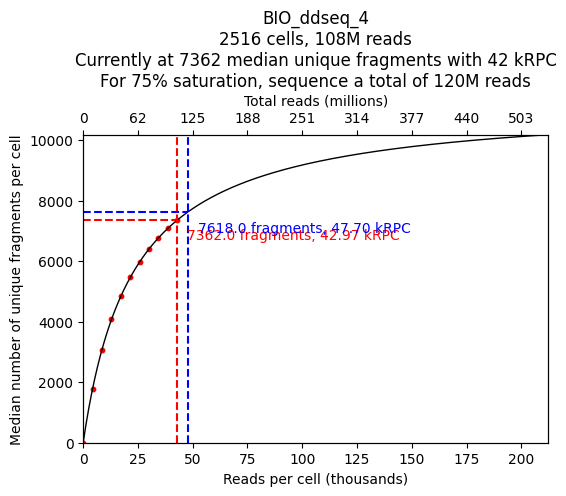

BIO_ddseq_4
2516 cells, 108M reads
Currently at 7362 median unique fragments with 42 kRPC
For 75% saturation, sequence a total of 120M reads


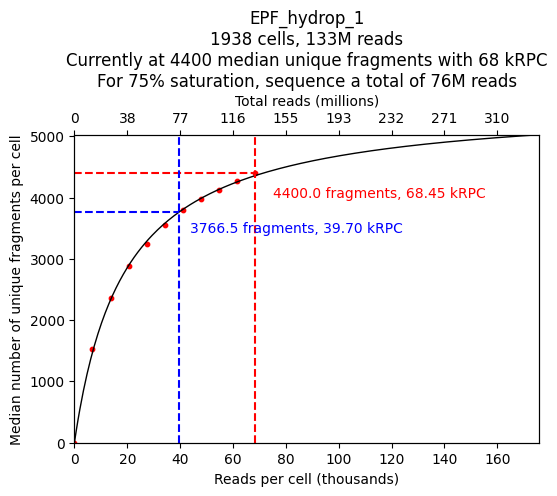

EPF_hydrop_1
1938 cells, 133M reads
Currently at 4400 median unique fragments with 68 kRPC
For 75% saturation, sequence a total of 76M reads


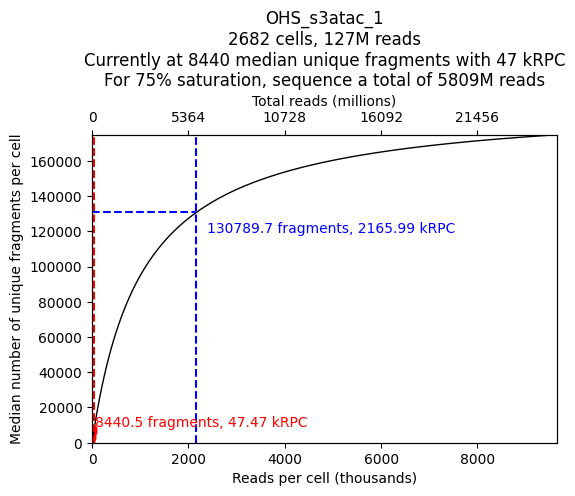

OHS_s3atac_1
2682 cells, 127M reads
Currently at 8440 median unique fragments with 47 kRPC
For 75% saturation, sequence a total of 5809M reads


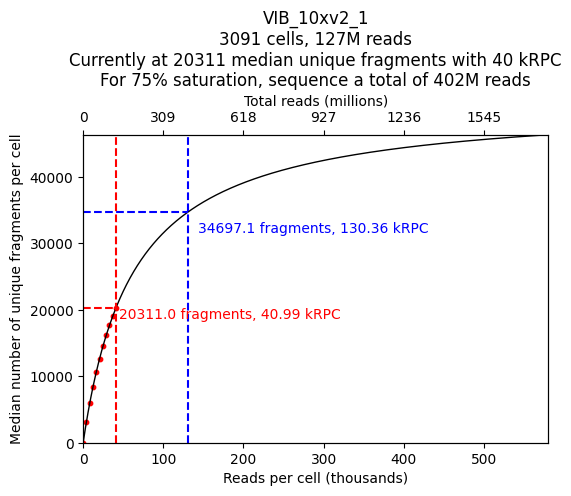

VIB_10xv2_1
3091 cells, 127M reads
Currently at 20311 median unique fragments with 40 kRPC
For 75% saturation, sequence a total of 402M reads


In [41]:
for sample, filepath in sampling_stats_path_dict.items():
    fig, ax = plt.subplots(figsize=(6, 4))

    stats_df = pd.read_csv(filepath, sep="\t", index_col=0)

    n_reads = read_count_dict[sample]

    stats_df["total_reads"] = n_reads * stats_df.index

    stats_df["mean_reads_per_barcode"] = (
        stats_df["total_reads"] / stats_df["cell_barcode_count"]
    )
    stats_df["mean_reads_per_barcode"].fillna(0, inplace=True)
    stats_df["duplication_rate"] = (
        stats_df["total_frag_count"] - stats_df["total_unique_frag_count"]
    ) / stats_df["total_frag_count"]
    stats_df["duplication_rate"] = stats_df["duplication_rate"].fillna(0)
    # stats_df["duplication_rate"] = (stats_df["total_frag_count"] - stats_df["total_unique_frag_count"]/stats_df["total_frag_count"])
    # select x/y data fro MM fit from subsampling stats
    x_data = np.array(stats_df.loc[0:, x_axis]) / 10**3
    y_data = np.array(stats_df.loc[0:, y_axis])
    # fit to MM function

    best_fit_ab, covar = curve_fit(MM, x_data, y_data, bounds=(0, +np.inf))

    # expand fit space
    x_fit = np.linspace(0, int(np.max(x_data) * 1000), num=100000)
    y_fit = MM(x_fit, *(best_fit_ab))
    # impute maximum saturation to plot as 95% of y_max
    y_val = best_fit_ab[0] * 0.95
    # subset x_fit space if bigger then y_val
    if y_val < max(y_fit):
        x_coef = np.where(y_fit >= y_val)[0][0]
        x_fit = x_fit[0:x_coef]
        y_fit = y_fit[0:x_coef]

    # plot model
    ax.plot(x_fit, MM(x_fit, *best_fit_ab), label="fitted", c="black", linewidth=1)
    # plot raw data
    ax.scatter(x=x_data, y=y_data, c="red", s=10)

    # mark curent saturation
    curr_x_idx = np.where(y_fit >= max(y_data))[0][0]
    curr_x_coef = max(x_data)
    curr_y_coef = max(y_data)
    if plot_current_saturation == True:
        ax.plot([curr_x_coef, curr_x_coef], [0, 9999999], linestyle="--", c="red")
        ax.plot([0, curr_x_coef], [curr_y_coef, curr_y_coef], linestyle="--", c="red")
        ax.text(
            x=curr_x_coef * 1.1,
            y=curr_y_coef * 0.9,
            s=str(round(curr_y_coef, 1))
            + " fragments, {:.2f}".format(curr_x_coef)
            + " kRPC",
            c="red",
            ha="left",
            va="bottom",
        )

    # Find read count for percent saturation
    y_val = best_fit_ab[0] * 0.9 * percentage_toplot
    # Find closest match in fit
    if max(y_fit) > y_val:
        x_idx = np.where(y_fit >= y_val)[0][0]
        x_coef = x_fit[x_idx]
        y_coef = y_fit[x_idx]
        # Draw vline
        ax.plot([x_coef, x_coef], [0, 9999999], linestyle="--", c="blue")
        # Draw hline
        ax.plot([0, x_coef], [y_coef, y_coef], linestyle="--", c="blue")
        # Plot imputed read count
        ax.text(
            x=x_coef * 1.1,
            y=y_coef * 0.9,
            s=str(round(y_coef, 1)) + " fragments, {:.2f}".format(x_coef) + " kRPC",
            c="blue",
            ha="left",
            va="bottom",
        )

    # get xlim value
    y_max = y_fit[-1] * 0.95
    x_idx = np.where(y_fit >= y_max)[0][0]
    x_max = x_fit[x_idx]
    ax.set_xlim([0, x_max])
    ax.set_ylim([0, y_max])

    # add second axis
    ax2 = ax.twiny()
    ax2.set_xticks(ax.get_xticks())
    upper_xticklabels = [
        str(int(x)) for x in ax.get_xticks() * n_cells_dict[sample] / 1000
    ]
    ax2.set_xticklabels(upper_xticklabels)
    ax2.set_xlabel("Total reads (millions)")
    ax2.set_xlim([0, x_max])

    # save figure
    ax.set_xlabel("Reads per cell (thousands)")

    # plt.yscale("log")
    # ax.set_xscale("log")

    ax.set_ylabel("Median number of unique fragments per cell")
    title_str = f"{sample}\n{n_cells_dict[sample]} cells, {round(read_count_dict[sample]/1000000)}M reads\nCurrently at {int(curr_y_coef)} median unique fragments with {int(curr_x_coef)} kRPC\nFor {int(percentage_toplot*100)}% saturation, sequence a total of {int(x_coef*n_cells_dict[sample]/1000)}M reads"
    ax.set_title(title_str)

    plt.savefig(f"plots_qc/{sample}_{y_axis}_saturation.png", dpi=300)
    plt.show()

    plt.close()
    print(title_str)

Now, I want the duplication rate (fraction of fragments that are duplicates) on the y-axis instead. I also want to find the depth where 75% of reads are duplicates.

In [42]:
percentage_toplot = 0.75
x_axis = "mean_reads_per_barcode"
y_axis = "duplication_rate"
plot_current_saturation = True

I use a michaelis-menten kinetic model with a maximum value fixed to 1 (number of duplicates cannot exceed 100%) to fit these values.

In [43]:
def MM_duplication(x, Km):
    """
    Define the Michaelis-Menten Kinetics model that will be used for the model fitting.
    """
    if Km > 0:
        y = x / (Km + x)
    else:
        y = 1e10
    return y

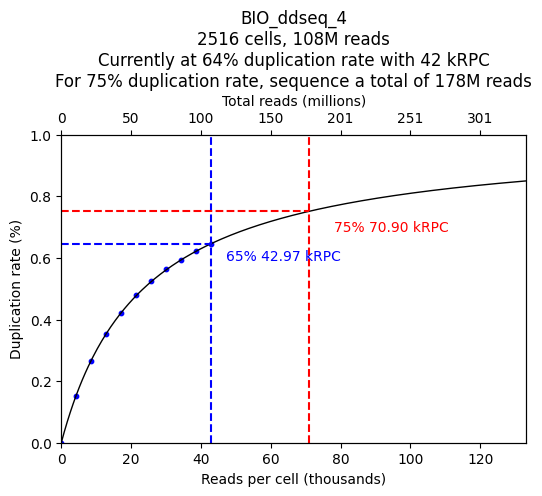

BIO_ddseq_4
2516 cells, 108M reads
Currently at 64% duplication rate with 42 kRPC
For 75% duplication rate, sequence a total of 178M reads


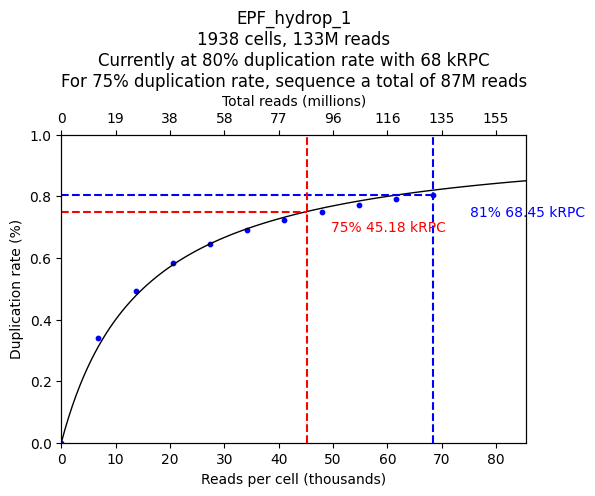

EPF_hydrop_1
1938 cells, 133M reads
Currently at 80% duplication rate with 68 kRPC
For 75% duplication rate, sequence a total of 87M reads


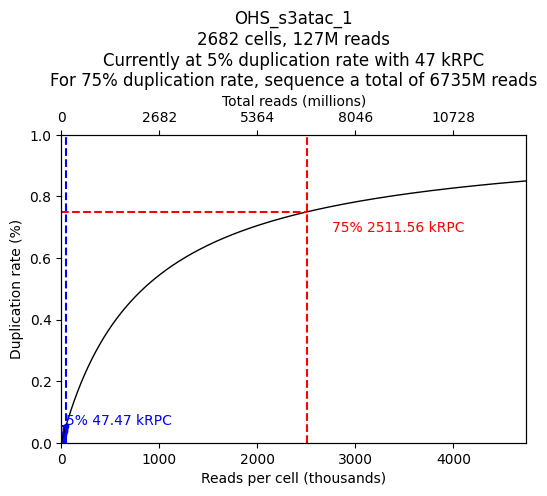

OHS_s3atac_1
2682 cells, 127M reads
Currently at 5% duplication rate with 47 kRPC
For 75% duplication rate, sequence a total of 6735M reads


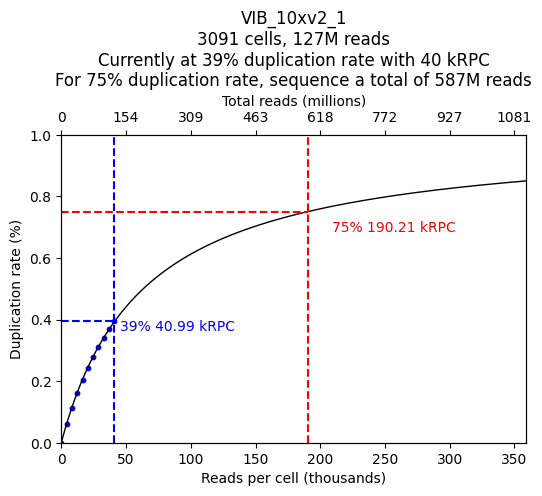

VIB_10xv2_1
3091 cells, 127M reads
Currently at 39% duplication rate with 40 kRPC
For 75% duplication rate, sequence a total of 587M reads


In [44]:
for sample, filepath in sampling_stats_path_dict.items():
    fig, ax = plt.subplots(figsize=(6, 4))

    stats_df = pd.read_csv(filepath, sep="\t", index_col=0)

    n_reads = read_count_dict[sample]

    stats_df["total_reads"] = n_reads * stats_df.index

    stats_df["mean_reads_per_barcode"] = (
        stats_df["total_reads"] / stats_df["cell_barcode_count"]
    )
    stats_df["mean_reads_per_barcode"].fillna(0, inplace=True)
    stats_df["duplication_rate"] = (
        stats_df["total_frag_count"] - stats_df["total_unique_frag_count"]
    ) / stats_df["total_frag_count"]
    stats_df["duplication_rate"] = stats_df["duplication_rate"].fillna(0)
    # stats_df["duplication_rate"] = (stats_df["total_frag_count"] - stats_df["total_unique_frag_count"]/stats_df["total_frag_count"])
    # select x/y data fro MM fit from subsampling stats
    x_data = np.array(stats_df.loc[0:, x_axis]) / 10**3
    y_data = np.array(stats_df.loc[0:, y_axis])
    # fit to MM function

    best_fit_ab, covar = curve_fit(MM_duplication, x_data, y_data, bounds=(0, +np.inf))

    # expand fit space
    x_fit = np.linspace(0, int(np.max(x_data) * 1000), num=100000)
    y_fit = MM_duplication(x_fit, *(best_fit_ab))
    # impute maximum saturation to plot as 95% of y_max
    y_val = best_fit_ab[0] * 0.95
    # subset x_fit space if bigger then y_val
    if y_val < max(y_fit):
        x_coef = np.where(y_fit >= y_val)[0][0]
        x_fit = x_fit[0:x_coef]
        y_fit = y_fit[0:x_coef]

    # plot model
    ax.plot(
        x_fit,
        MM_duplication(x_fit, *best_fit_ab),
        label="fitted",
        c="black",
        linewidth=1,
    )
    # plot raw data
    ax.scatter(x=x_data, y=y_data, c="blue", s=10)

    # mark curent saturation
    curr_x_idx = np.where(y_fit >= max(y_data))[0][0]
    curr_x_coef = max(x_data)
    curr_y_coef = max(y_data)
    if plot_current_saturation == True:
        ax.plot([curr_x_coef, curr_x_coef], [0, 99999], linestyle="--", c="blue")
        ax.plot([0, curr_x_coef], [curr_y_coef, curr_y_coef], linestyle="--", c="blue")
        ax.text(
            x=curr_x_coef * 1.1,
            y=curr_y_coef * 0.9,
            s=str(round(100 * curr_y_coef)) + "% {:.2f}".format(curr_x_coef) + " kRPC",
            c="blue",
            ha="left",
            va="bottom",
        )

    # Find read count for percent saturation
    y_val = percentage_toplot
    # Find closest match in fit
    if max(y_fit) > y_val:
        x_idx = np.where(y_fit >= y_val)[0][0]
        x_coef = x_fit[x_idx]
        y_coef = y_fit[x_idx]
        # Draw vline
        ax.plot([x_coef, x_coef], [0, 99999], linestyle="--", c="red")
        # Draw hline
        ax.plot([0, x_coef], [y_coef, y_coef], linestyle="--", c="red")
        # Plot imputed read count
        ax.text(
            x=x_coef * 1.1,
            y=y_coef * 0.9,
            s=str(round(100 * percentage_toplot)) + "% {:.2f}".format(x_coef) + " kRPC",
            c="red",
            ha="left",
            va="bottom",
        )

    # get xlim value
    y_max = 0.85
    x_idx = np.where(y_fit >= y_max)[0][0]
    x_max = x_fit[x_idx]
    ax.set_xlim([0, x_max])
    ax.set_ylim([0, y_max])

    # add second axis
    ax2 = ax.twiny()
    ax2.set_xticks(ax.get_xticks())
    upper_xticklabels = [
        str(int(x)) for x in ax.get_xticks() * n_cells_dict[sample] / 1000
    ]
    ax2.set_xticklabels(upper_xticklabels)
    ax2.set_xlabel("Total reads (millions)")
    ax2.set_xlim([0, x_max])

    ax.set_xlabel("Reads per cell (thousands)")
    # plt.yscale("log")
    # ax.set_xscale("log")

    ax.set_ylabel("Duplication rate (%)")
    ax.set_ylim([0, 1])
    title_str = f"{sample}\n{n_cells_dict[sample]} cells, {round(read_count_dict[sample]/1000000)}M reads\nCurrently at {int(curr_y_coef*100)}% duplication rate with {int(curr_x_coef)} kRPC\nFor {int(percentage_toplot*100)}% duplication rate, sequence a total of {int(x_coef*n_cells_dict[sample]/1000)}M reads"
    ax.set_title(title_str)

    plt.savefig(f"plots_qc/{sample}_{y_axis}_saturation.png", dpi=300)
    plt.show()

    plt.close()
    print(title_str)

# 3. Gather QC stats from pipeline output and cisTopic
No need to read this, we are parsing information needed to make the plots below.

In [45]:
import pandas as pd
import polars as pl
import glob
import numpy as np
import os
import pickle

%load_ext lab_black

The lab_black extension is already loaded. To reload it, use:
  %reload_ext lab_black


In [46]:
verbose = False

In [47]:
samples = sorted(fragments_paths_dict.keys())
df_stats = pd.DataFrame(index=pd.Index(samples))
tsv_list = sorted(glob.glob(f"selected_barcodes/*otsu.txt"))
cell_count_dict = {}
for tsv in tsv_list:
    sample = tsv.split("/")[-1].split("_bc_passing_filters_otsu")[0]
    # print(sample)
    df = pd.read_csv(tsv, sep="\t", index_col=0)
    cell_count_dict[sample] = len(df)
    df_stats.loc[sample, "n_cells"] = len(df)

df_stats

,n_cells
BIO_ddseq_4,2515.0
EPF_hydrop_1,1937.0
OHS_s3atac_1,2681.0
VIB_10xv2_1,3090.0


### 3a. Barcode correction stats

In [48]:
directory = f"{output_dir}/data/reports/barcode/"
for sample in df_stats.index:
    file = directory + sample + "_____R1.corrected.bc_stats.log"
    if os.path.exists(file):
        # print(f"{sample}: {file}")
        df = pd.read_csv(file, sep="\t\t|\t", engine="python", index_col=0, header=None)
        # print(df)
        if "ddseq" in sample:
            nreads = df.loc["nbr_reads:", 1]
            nbarcodes_total = df.loc[
                "nbr_reads_with_bc1_bc2_bc3_correct_or_correctable", 1
            ]
            percentage_correct_barcodes = nbarcodes_total / nreads * 100
        else:
            nreads = df.loc["nbr_reads:", 1]
            nbarcodes_total = df.loc["total_bc_found", 1]
            percentage_correct_barcodes = nbarcodes_total / nreads * 100

        if verbose == True:
            print(f"nreads: {nreads}")
            print(f"nbarcodes_total: {nbarcodes_total}")
            print(f"percentage_correct_barcodes: {percentage_correct_barcodes}")
            print("-------------------------------------\n")

        df_stats.loc[sample, "n_reads"] = int(nreads)
        df_stats.loc[sample, "%_correct_barcodes"] = round(
            percentage_correct_barcodes, 2
        )
    else:
        print(f"{file} does not exist!")

### 3b. Mapping statistics

In [49]:
directory = f"{output_dir}/data/reports/mapping_stats/"

for sample in df_stats.index:
    file = directory + sample + "_____R1.mapping_stats.tsv"
    if os.path.exists(file):
        print(f"{sample}: {file}")
        df = pd.read_csv(file, sep="\t", engine="python", index_col=0, header=0)
        if verbose == True:
            print(df.astype(int))
            print("\n")

        percent_mapq30 = (
            df.loc["Reads mapped with MAPQ>30:"] / df.loc["raw total sequences:"] * 100
        )
        avg_insert = df.loc["insert size average:"]
        avg_map_quality = df.loc["average quality:"]
        r1_length = df.loc["maximum first fragment length:"]
        r2_length = df.loc["maximum last fragment length:"]

        if verbose == True:

            print(f"read 1 length: {int(r1_length)}")
            print(f"read 2 length: {int(r2_length)}")
            print(f"average map quality: {round(avg_map_quality, 2)}")
            print(f"percent mapq30: {round(percent_mapq30, 2)}")
            print(f"insert size average: {avg_insert}")
            print("-------------------------------------\n")

        df_stats.loc[sample, "r1_length"] = int(r1_length)
        df_stats.loc[sample, "r2_length"] = int(r2_length)
        df_stats.loc[sample, "avg_insert_size"] = int(avg_insert)
        df_stats.loc[sample, "%_mapq30"] = round(percent_mapq30.iloc[0], 2)
        df_stats.loc[sample, "avg_map_quality"] = round(avg_map_quality.iloc[0], 2)
    elif verbose == True:
        print(f"{file}")

BIO_ddseq_4: ATACflow_tutorial_preprocessing_out/data/reports/mapping_stats/BIO_ddseq_4_____R1.mapping_stats.tsv
EPF_hydrop_1: ATACflow_tutorial_preprocessing_out/data/reports/mapping_stats/EPF_hydrop_1_____R1.mapping_stats.tsv
OHS_s3atac_1: ATACflow_tutorial_preprocessing_out/data/reports/mapping_stats/OHS_s3atac_1_____R1.mapping_stats.tsv
VIB_10xv2_1: ATACflow_tutorial_preprocessing_out/data/reports/mapping_stats/VIB_10xv2_1_____R1.mapping_stats.tsv


### 3c. Single-cell level statistics

In [50]:
metadata_path_dict = {
    x.split("/")[-1].split(f"__")[0].split(".")[0]: x
    for x in sorted(glob.glob(f"{cistopic_qc_out}/*metadata*pkl"))
}
if verbose:
    print(metadata_path_dict)

selected_cells_path_dict = {
    x.split("/")[-1].split(f"_bc")[0].split(".")[0]: x
    for x in sorted(glob.glob(f"selected_barcodes/*.pkl"))
}
if verbose:
    print(selected_cells_path_dict)

Read the cisTopic output.

In [51]:
df_merged = pd.DataFrame()
df_scstats_merged = pd.DataFrame()
for sample in metadata_path_dict.keys():
    with open(metadata_path_dict[sample], "rb") as f:
        df = pickle.load(f)

    with open(selected_cells_path_dict[sample], "rb") as f:
        selected_barcodes = pickle.load(f)

    df = df.loc[selected_barcodes]
    df_median = df.median()
    df_median.index = ["Median_" + x.lower() for x in df_median.index]
    df_median["total_nr_frag_in_selected_barcodes"] = sum(df["Total_nr_frag"])
    df_median["total_nr_unique_frag_in_selected_barcodes"] = sum(df["Unique_nr_frag"])
    df_median["total_nr_unique_frag_in_selected_barcodes_in_regions"] = sum(
        df["Unique_nr_frag_in_regions"]
    )
    df_median["n_barcodes_merged"] = len(
        [x for x in [x.split("__")[0] for x in df.index] if "_" in x]
    )
    df_median["frac_barcodes_merged"] = len(
        [x for x in [x.split("__")[0] for x in df.index] if "_" in x]
    ) / len(df)
    df_merged = pd.concat([df_merged, df_median], axis=1)
    df["sample_id"] = sample
    df_scstats_merged = pd.concat([df_scstats_merged, df], axis=0)

df_merged.columns = metadata_path_dict.keys()

df_merged = df_merged.T
df_merged = df_merged[
    [
        "Median_total_nr_frag",
        "Median_unique_nr_frag",
        "Median_dupl_rate",
        "Median_total_nr_frag_in_regions",
        "Median_frip",
        "Median_tss_enrichment",
        "total_nr_frag_in_selected_barcodes",
        "total_nr_unique_frag_in_selected_barcodes",
        "total_nr_unique_frag_in_selected_barcodes_in_regions",
        "n_barcodes_merged",
        "frac_barcodes_merged",
    ]
]

df_scstats_merged["tech"] = "user_sample"
df_merged["tech"] = "user_sample"

/tmp/ipykernel_1236946/4208782870.py:11: FutureWarning: The default value of numeric_only in DataFrame.median is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  df_median = df.median()
/tmp/ipykernel_1236946/4208782870.py:11: FutureWarning: The default value of numeric_only in DataFrame.median is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  df_median = df.median()
/tmp/ipykernel_1236946/4208782870.py:11: FutureWarning: The default value of numeric_only in DataFrame.median is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this 

These are variables necessary for plotting (order of samples, color palettes, ...)

In [52]:
tech_order = [
    "10xv1",
    "10xv11",
    "10xv11c",
    "10xv2",
    "10xmultiome",
    "mtscatac",
    "mtscatacfacs",
    "ddseq",
    "s3atac",
    "hydrop",
    "user_sample",
]

tech_color_palette = {
    "10xv2": "#1b9e77",
    "10xv1": "#d95f02",
    "10xv11": "#7570b3",
    "10xv11c": "#7570b3",
    "10xmultiome": "#e7298a",
    "mtscatac": "#66a61e",
    "mtscatacfacs": "#66a61e",
    "ddseq": "#e6ab02",
    "s3atac": "#a6761d",
    "hydrop": "#666666",
    "user_sample": "#FF0000",
}

var_alias_dict = {
    "Log_total_nr_frag": "Total Fragments",
    "Log_unique_nr_frag": "Total Fragments",
    "Total_nr_frag": "Total Fragments",
    "Unique_nr_frag": "Unique Fragments",
    "Dupl_nr_frag": "Duplicate Fragments",
    "Dupl_rate": "% Duplicate Fragments",
    "Total_nr_frag_in_regions": "Total Fragments in Regions",
    "Unique_nr_frag_in_regions": "Unique Fragments\nin Peaks",
    "Unique_nr_frag_in_regions_k": "Unique Fragments\nin Peaks (x1000)",
    "FRIP": "Fraction of Unique\nFragments in Peaks",
    "TSS_enrichment": "TSS\nEnrichment",
    "sample_id": "Sample",
    "tech": "Technology",
    "seurat_cell_type_pred_score": "Seurat score",
    "Doublet_scores_fragments": "Scrublet score",
}

order_dict = {
    "10xmultiome": [
        "SAN_10xmultiome_1.FIXEDCELLS",
        "SAN_10xmultiome_2.FIXEDCELLS",
        "CNA_10xmultiome_1.FIXEDCELLS",
        "CNA_10xmultiome_2.FIXEDCELLS",
        "VIB_10xmultiome_2.FIXEDCELLS",
        "VIB_10xmultiome_1.FIXEDCELLS",
    ],
    "10xv1": ["VIB_10xv1_1.FIXEDCELLS", "VIB_10xv1_2.FIXEDCELLS"],
    "10xv11": [
        "TXG_10xv11_1.FIXEDCELLS",
        "CNA_10xv11_3.FIXEDCELLS",
        "CNA_10xv11_2.FIXEDCELLS",
        "CNA_10xv11_1.FIXEDCELLS",
        "STA_10xv11_1.FIXEDCELLS",
        "STA_10xv11_2.FIXEDCELLS",
    ],
    "10xv11c": ["CNA_10xv11c_1.FIXEDCELLS", "CNA_10xv11c_2.FIXEDCELLS"],
    "10xv2": [
        "VIB_10xv2_2.FIXEDCELLS",
        "VIB_10xv2_1.FIXEDCELLS",
        "TXG_10xv2_1.FIXEDCELLS",
        "TXG_10xv2_2.FIXEDCELLS",
        "CNA_10xv2_1.FIXEDCELLS",
        "CNA_10xv2_2.FIXEDCELLS",
    ],
    "ddseq": [
        "HAR_ddseq_1.FIXEDCELLS",
        "HAR_ddseq_2.FIXEDCELLS",
        "BIO_ddseq_2.FIXEDCELLS",
        "BIO_ddseq_4.FIXEDCELLS",
        "BIO_ddseq_1.FIXEDCELLS",
        "BIO_ddseq_3.FIXEDCELLS",
        "UCS_ddseq_2.FIXEDCELLS",
        "UCS_ddseq_1.FIXEDCELLS",
    ],
    "hydrop": [
        "EPF_hydrop_4.FIXEDCELLS",
        "EPF_hydrop_3.FIXEDCELLS",
        "EPF_hydrop_1.FIXEDCELLS",
        "EPF_hydrop_2.FIXEDCELLS",
        "VIB_hydrop_2.FIXEDCELLS",
        "VIB_hydrop_1.FIXEDCELLS",
        "CNA_hydrop_3.FIXEDCELLS",
        "CNA_hydrop_1.FIXEDCELLS",
        "CNA_hydrop_2.FIXEDCELLS",
    ],
    "mtscatacfacs": ["BRO_mtscatacfacs_1.FIXEDCELLS", "BRO_mtscatacfacs_2.FIXEDCELLS"],
    "mtscatac": [
        "MDC_mtscatac_1.FIXEDCELLS",
        "MDC_mtscatac_2.FIXEDCELLS",
        "CNA_mtscatac_2.FIXEDCELLS",
        "CNA_mtscatac_1.FIXEDCELLS",
    ],
    "s3atac": ["OHS_s3atac_1.FIXEDCELLS", "OHS_s3atac_2.FIXEDCELLS"],
    "user_sample": samples,
}

ylim_dict = {
    "Unique_nr_frag_in_regions": [0, 20000],
    "Unique_nr_frag_in_regions_k": [0, 20],
    "FRIP": [0, 1],
    "TSS_enrichment": [0, 45],
}

order_dict_tech_ultrashort = {
    "10xmultiome": ["MO Sa1", "MO Sa2", "MO C1", "MO C2", "MO V2", "MO V1"],
    "10xv1": ["v1 V1", "v1 V2"],
    "10xv11": ["v1.1 T1", "v1.1 C3", "v1.1 C2", "v1.1 C1", "v1.1 St1", "v1.1 St2"],
    "10xv11c": ["v1.1c C1", "v1.1c C2"],
    "10xv2": ["v2 V2", "v2 V1", "v2 T1", "v2 T2", "v2 C1", "v2 C2"],
    "ddseq": [
        "ddS H1",
        "ddS H2",
        "ddS Bi2",
        "ddS Bi4",
        "ddS Bi1",
        "ddS Bi3",
        "ddS U2",
        "ddS U1",
    ],
    "hydrop": [
        "Hy E4",
        "Hy E3",
        "Hy E1",
        "Hy E2",
        "Hy V2",
        "Hy V1",
        "Hy C3",
        "Hy C1",
        "Hy C2",
    ],
    "mtscatacfacs": ["mt* Br1", "mt* Br2"],
    "mtscatac": ["mt M1", "mt M2", "mt C2", "mt C1"],
    "s3atac": ["s3 O1", "s3 O2"],
    "user_sample": samples,
}

Load the reference data from De Rop et al., 2023 and combine it with the user samples:

In [53]:
df_scstats_merged_benchmark = pd.read_csv(
    "PUMATAC_dependencies/data/fixedcells_cto_merged.tsv",
    sep="\t",
)

df_scstats_merged_benchmark.index = df_scstats_merged_benchmark["Unnamed: 0"]
df_scstats_merged_benchmark.drop(["Unnamed: 0.1", "Unnamed: 0"], inplace=True, axis=1)
df_scstats_merged_benchmark.index = [
    x.replace("CNA_10xv11_4", "CNA_10xv11c_1")
    .replace("CNA_10xv11_5", "CNA_10xv11c_2")
    .replace("BRO_mtscatac", "BRO_mtscatacfacs")
    for x in df_scstats_merged_benchmark.index
]
df_scstats_merged_benchmark["sample_id"] = [
    x.replace("CNA_10xv11_4", "CNA_10xv11c_1")
    .replace("CNA_10xv11_5", "CNA_10xv11c_2")
    .replace("BRO_mtscatac", "BRO_mtscatacfacs")
    for x in df_scstats_merged_benchmark["sample_id"]
]
df_scstats_merged_benchmark["tech"] = [
    x.split("___")[-1].split("_")[1] for x in df_scstats_merged_benchmark.index
]

df_scstats_merged_benchmark = df_scstats_merged_benchmark[df_scstats_merged.columns]

df_scstats_merged = pd.concat([df_scstats_merged_benchmark, df_scstats_merged])

metadata_bc_df_filtered_merged = df_scstats_merged.copy()
metadata_bc_df_filtered_merged["Unique_nr_frag_in_regions_k"] = (
    metadata_bc_df_filtered_merged["Unique_nr_frag_in_regions"] / 1000
)

In [54]:
df_scstats_merged.columns

Index(['Log_total_nr_frag', 'Log_unique_nr_frag', 'Total_nr_frag',
       'Unique_nr_frag', 'Dupl_nr_frag', 'Dupl_rate',
       'Total_nr_frag_in_regions', 'Unique_nr_frag_in_regions', 'FRIP',
       'TSS_enrichment', 'sample_id', 'tech'],
      dtype='object')

### 3d. Sequencing efficiency statistics

In [55]:
for user_sample in df_stats.index:
    df_stats.at[user_sample, "total_nr_frag_in_selected_barcodes"] = (
        df_scstats_merged.groupby("sample_id")["Total_nr_frag"].sum().loc[user_sample]
    )
    df_stats.at[user_sample, "total_nr_unique_frag_in_selected_barcodes"] = (
        df_scstats_merged.groupby("sample_id")["Unique_nr_frag"].sum().loc[user_sample]
    )
    df_stats.at[user_sample, "total_nr_unique_frag_in_selected_barcodes_in_regions"] = (
        df_scstats_merged.groupby("sample_id")["Unique_nr_frag_in_regions"]
        .sum()
        .loc[user_sample]
    )

df_sub = df_stats[
    [
        "n_reads",
        "total_nr_frag_in_selected_barcodes",
        "total_nr_unique_frag_in_selected_barcodes",
        "total_nr_unique_frag_in_selected_barcodes_in_regions",
    ]
]

df_sub["with_correct_barcode"] = (
    df_sub["n_reads"] * df_stats["%_correct_barcodes"] / 100
)

df_sub["mapped"] = df_sub["with_correct_barcode"] * df_stats["%_mapq30"] / 100

df_sub = df_sub.div(df_sub["n_reads"], axis=0)

df_sub["n_reads"] = df_sub["n_reads"] - df_sub["with_correct_barcode"]
df_sub["with_correct_barcode"] = df_sub["with_correct_barcode"] - df_sub["mapped"]
df_sub["mapped"] = df_sub["mapped"] - df_sub["total_nr_frag_in_selected_barcodes"]
df_sub["total_nr_frag_in_selected_barcodes"] = (
    df_sub["total_nr_frag_in_selected_barcodes"]
    - df_sub["total_nr_unique_frag_in_selected_barcodes"]
)
df_sub["total_nr_unique_frag_in_selected_barcodes"] = (
    df_sub["total_nr_unique_frag_in_selected_barcodes"]
    - df_sub["total_nr_unique_frag_in_selected_barcodes_in_regions"]
)

df_sub.columns = [
    "No correct barcode",
    "Duplicate fragments in cells",
    "Unique fragments in cells, not in peaks",
    "Unique fragments in cells and in peaks",
    "Not mapped properly",
    "Fragments in background noise barcodes",
]

df_sub = df_sub[
    [
        "No correct barcode",
        "Not mapped properly",
        "Fragments in background noise barcodes",
        "Duplicate fragments in cells",
        "Unique fragments in cells, not in peaks",
        "Unique fragments in cells and in peaks",
    ]
]

In [56]:
if not "No correct barcode" in df_stats.columns:
    df_stats = pd.concat([df_stats, df_sub], axis=1)

Read the reference stats from De Rop et al., 2023.

In [57]:
df_stats_reference = pd.read_csv(
    "PUMATAC_dependencies/data/fixedcells_general_statistics.tsv", sep="\t", index_col=0
)

df_stats_reference["n_cells"] = df_stats_reference["cells"]
df_stats_reference["n_reads"] = df_stats_reference["reads"]
df_stats_reference["with_correct_barcode"] = (
    df_stats_reference["n_reads"] * df_stats_reference["%_correct_barcodes"] / 100
)
df_stats_reference["mapped"] = (
    df_stats_reference["with_correct_barcode"] * df_stats_reference["%_mapq30"] / 100
)
df_stats_reference = df_stats_reference[df_stats.columns]
df_stats_reference.index = [x + ".FIXEDCELLS" for x in df_stats_reference.index]
df_stats_reference["tech"] = [x.split("_")[1] for x in df_stats_reference.index]

df_stats["tech"] = "user_sample"
df_stats_merged = pd.concat([df_stats_reference, df_stats])
losses_df_normalized = df_stats_merged[
    [
        "No correct barcode",
        "Not mapped properly",
        "Fragments in background noise barcodes",
        "Duplicate fragments in cells",
        "Unique fragments in cells, not in peaks",
        "Unique fragments in cells and in peaks",
        "tech",
    ]
]

losses_df_normalized.columns = [
    "No correct barcode",
    "Not mapped properly",
    "Fragments in noise barcodes",
    "Duplicate fragments in cells",
    "Unique, in cells, not in peaks",
    "Unique, in cells, in peaks",
    "tech",
]

Some variables necessary for plotting.

In [58]:
order = [
    "tech",
    "No correct barcode",
    "Not mapped properly",
    "Fragments in noise barcodes",
    "Duplicate fragments in cells",
    "Unique, in cells, not in peaks",
    "Unique, in cells, in peaks",
]

order = order[::-1]

losses_color_palette = palettable.cartocolors.qualitative.Safe_7.get_mpl_colormap()

tech_alias_dict = {
    "10xmultiome": "10x\nMultiome",
    "10xv1": "10x v1",
    "10xv11": "10x v1.1",
    "10xv11c": "10x v1.1\ncontrols",
    "10xv2": "10x v2",
    "ddseq": "Bio-Rad\nddSEQ SureCell",
    "hydrop": "HyDrop",
    "mtscatac": "mtscATAC-seq",
    "mtscatacfacs": "*",
    "s3atac": "s3-ATAC",
    "user_sample": "User samples",
}

# 4. Plot and compare to De Rop et al., 2023 benchmark

In [59]:
sns.set_context("notebook")
sns.set_style("darkgrid")

### 4a. Sequencing efficiency & Single-cell statistics

In [60]:
individual_barplot_width = 0.5
individual_plot_row_height = 4

/tmp/ipykernel_1236946/2180752583.py:147: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout()


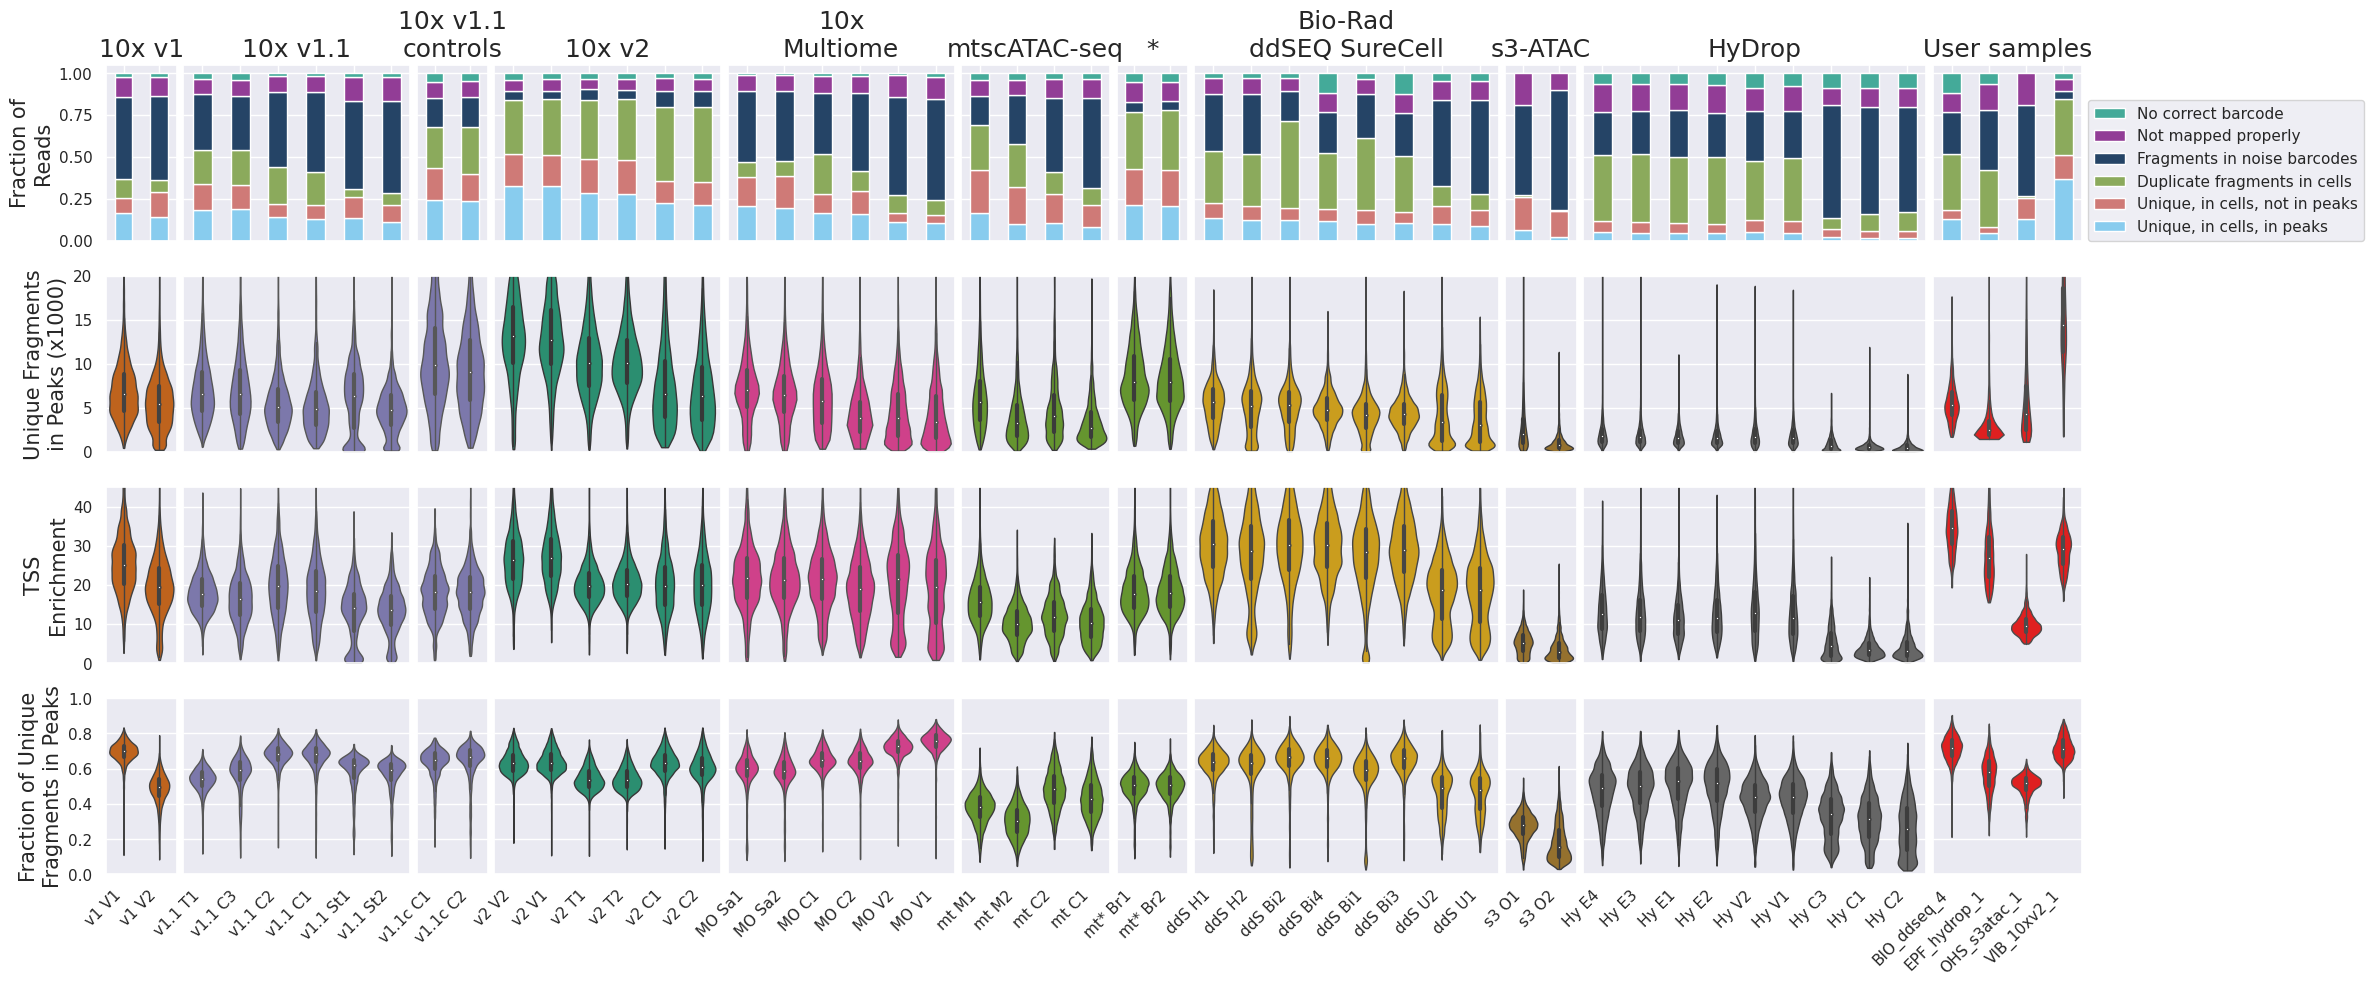

In [61]:
variables_list = ["Unique_nr_frag_in_regions_k", "TSS_enrichment", "FRIP"]
variables_list2 = [
    "seurat_cell_type_pred_score",
    # "Doublet_scores_fragments",
]
n_addendum_cols = 0
n_samples = len(metadata_bc_df_filtered_merged["sample_id"].unique())
n_var = len(variables_list) + len(variables_list2)

n_not_in_variables = 2

# initialize gridspec
from matplotlib.gridspec import GridSpec

fig = plt.figure(
    figsize=(
        individual_barplot_width * (n_samples + n_addendum_cols),
        individual_plot_row_height * n_var,
    ),
)

gs = GridSpec(
    len(variables_list) + len(variables_list2) + n_not_in_variables,
    n_samples + n_addendum_cols,
    figure=fig,
)


## draw losses at the top

grid_start = 0
for tech in tech_order:
    df_tmp = losses_df_normalized[losses_df_normalized["tech"] == tech]
    df_tmp = df_tmp.reindex(order_dict[tech], fill_value=0)
    df_tmp = df_tmp[order]
    df_tmp = df_tmp.loc[order_dict[tech]]

    n_samples_in_tech = len(df_tmp)
    grid_end = grid_start + n_samples_in_tech
    ax = fig.add_subplot(gs[0, grid_start:grid_end])

    df_tmp.plot.bar(
        stacked=True,
        ax=ax,
        width=individual_barplot_width,
        colormap=losses_color_palette,
    )

    # .set_ylim(ylim_dict[variable])
    ax.get_legend().remove()

    # only set title on top row
    ax.set_title(tech_alias_dict[tech], fontsize=18)
    # only set y label on left col
    if tech == tech_order[0]:
        ax.set_ylabel("Fraction of\nReads", fontsize=15)
    else:
        ax.set_ylabel(None)
        ax.set_yticklabels([])

    ax.set(xlabel="")
    ax.set_xticklabels([])

    # start coordinate of next tech is end coordinate of previous tech
    grid_start = grid_end


handles, labels = plt.gca().get_legend_handles_labels()
order_index = [5, 4, 3, 2, 1, 0]
plt.legend(
    [handles[idx] for idx in order_index],
    [labels[idx] for idx in order_index],
    loc=(1.04, 0),
)


## draw variables_list
grid_start = 0
for tech in tech_order:
    # print(grid_start)
    # print(tech)
    # subset df to tech
    df_tmp = metadata_bc_df_filtered_merged[
        metadata_bc_df_filtered_merged["tech"] == tech
    ]

    # set quick palette
    color = tech_color_palette[tech]
    palette_tmp = {
        x: color for x in metadata_bc_df_filtered_merged["sample_id"].unique()
    }

    n_samples_in_tech = len(df_tmp["sample_id"].unique())
    # print(n_samples_in_tech)
    grid_end = grid_start + n_samples_in_tech
    for variable in variables_list:
        # print(variable)
        # now determine correct location on gridspec
        ax = fig.add_subplot(
            gs[variables_list.index(variable) + 1, grid_start:grid_end]
        )

        sns.violinplot(
            data=df_tmp,
            x="sample_id",
            y=variable,
            # hue="sample_id",
            order=order_dict[tech],
            palette=palette_tmp,
            ax=ax,
            showfliers=False,
            cut=0,
            bw=0.15,
            inner="box",
            linewidth=1,
        )

        if not variable == "Unique_nr_frag_in_regions_k":
            ax.set_ylim(ylim_dict[variable])
        else:
            ax.set_ylim(ylim_dict[variable])

        # ax.get_legend().remove()

        # only set y label on left col or s3-atac
        if tech == tech_order[0]:
            ax.set_ylabel(var_alias_dict[variable], fontsize=15)
        else:
            ax.set_ylabel(None)
            ax.set_yticklabels([])

        ax.set(xlabel="")
        ax.set_xticklabels([])

        ax.set(xlabel="")
        if variable == variables_list[-1]:
            ax.set_xticklabels(
                labels=order_dict_tech_ultrashort[tech], rotation=45, ha="right"
            )
        else:
            ax.set_xticklabels([])

    # start coordinate of next tech is end coordinate of previous tech
    grid_start = grid_end

# plt.rcParams["font.weight"] = "bold"
plt.tight_layout()
# plt.savefig(f"plts_scrap/fixedcells__boxplots_cellvars.png", dpi=600, facecolor="white")
# plt.savefig(f"plts_scrap/fixedcells__boxplots_cellvars.svg", dpi=600, facecolor="white")

# plt.savefig(
#     f"plts_scrap/fixedcells__boxplots_cellvars_small.png", dpi=300, facecolor="white"
# )
# plt.savefig(
#     f"plts_scrap/fixedcells__boxplots_cellvars_small.svg", dpi=300, facecolor="white"
# )
plt.show()
plt.close()

### 4c. Sequencing-depth controlled statistics